## Setup

In [1]:
# import
import xarray as xr
import numpy as np

from rhwhitepackages.readwrite import *
from rhwhitepackages.plotting import *

from cartopy.util import add_cyclic_point

import scipy
from scipy import stats

# import matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.path as mpath
import matplotlib.ticker as mticker

%matplotlib inline

# Colormaps
cmap_def,cmap_wc,cmap_reds = get_colormaps()

## Functions

In [2]:
# define functions

def readseasons(Dir,exp,startyr,nyears,name,camversion='cam2'):
    #atmfields[exp]['annual'] = readfiles(Dir,'Annual' + str(startyr) + '_' + str(nyears) + '_mean_' + name + '.cam2.h0.nc')
    #toPlev(atmfields[exp]['annual'],plevs)

    for seas in ['ANN','DJF','MAM','JJA','SON']:
        try:
            atmfields[exp][seas] = xrOpen(Dir + '/' + seas + str(startyr) + '_' + str(nyears) + '_mean_' + name + '.' + camversion + '.h0.nc')
        except SystemExit:
            atmfields[exp][seas]=None    

    atmfields['p' + exp] = {}
            
    for seas in ['ANN','DJF','MAM','JJA','SON']:
        try:
            atmfields['p' + exp][seas] = xrOpen(Dir + '/' + seas + str(startyr) + '_' + str(nyears) + '_mean_Xpl_' + name + '.' + camversion + '.h0.nc')
        except SystemExit:
            #try:
            #    atmfields['p' + exp][seas] = xarrayOpen(Dir + '/' + seas + str(startyr) + '_' + str(nyears) + '_mean_pl_' + name + '.cam2.h0.nc')
            #except:
            print 'missing pl file for ' + exp
            #    atmfields['p' + exp][seas] = None
            
            

def add_lon(toplot,coord):
    lon_idx = toplot.dims.index(coord)
    cyclic_data, cyclic_coord = add_cyclic_point(toplot.values,
                                                 coord=toplot.coords[coord],
                                                 axis=lon_idx)

    # Copy and add the cyclic coordinate and data
    new_coords = dict(toplot.coords)
    new_coords[coord] = cyclic_coord
    new_values = cyclic_data

    new_da = xr.DataArray(new_values, dims=toplot.dims, coords=new_coords)
    return(new_da)
            
    
def setaxes_latN(title,units,ps=1000,pt=10,fontsize=16,log=True):
    ps = ps
    pt = pt    
    if log:
        plt.yscale('log')   
        plt.gca().set_yticks([1000,500,200,100,50,20,10,5,2,1,])
        plt.gca().set_yticklabels(['1000','500','200','100','50','20','10','5','2','1'])

    else: 
        plt.gca().set_yticks([1000,750,500,250])
        plt.gca().set_yticklabels(['1000','750','500','250'])
       
        
    plt.gca().invert_yaxis()
    
    plt.gca().set_xticks([10,30,40,50,60,70,80,90])
    plt.gca().set_xticklabels(['10N','30N','40N','50N','60N','70N','80N','90N'])    

    
    #plt.gca().set_xticks([-80,-60,-40,-20,0,10,20,30,40,50,60,70,80])
    #plt.gca().set_xticklabels(['80S','60S','40S','20S','EQ','10N','20N','30N','40N','50N','60N','70N','80N'])    
    plt.xlim([0,90]) 
    plt.ylim([ps,pt]) 
    plt.title(title,loc='left')
    plt.xlabel('')
    plt.ylabel('')
    plt.text(95,ps+100,units,fontsize = fontsize)

def setaxes_lon(title,units,ps=1000,pt=10):
    ps = ps
    pt = pt    
    plt.yscale('log')  
    plt.gca().invert_yaxis()
        
    plt.gca().set_yticks([1000,500,200,100,50,20,10])
    plt.gca().set_yticklabels(['1000','500','200','100','50','20','10'])

    plt.gca().set_xticks([0,60,120,180,240,300])
    plt.gca().set_xticklabels(['0','60E','120E','180','120W','60W'])    

    
    #plt.gca().set_xticks([-80,-60,-40,-20,0,10,20,30,40,50,60,70,80])
    #plt.gca().set_xticklabels(['80S','60S','40S','20S','EQ','10N','20N','30N','40N','50N','60N','70N','80N'])    
    #plt.xlim([xmin,xmax]) 
    plt.ylim([ps,pt]) 
    plt.title(title,loc='left')
    plt.xlabel('')
    plt.ylabel('')
    plt.text(90,ps+100,units)
    
     
        
def setaxes_latNS(title,units,ps=1000,pt=10,fontsize=16):
    ps = ps
    pt = pt    
    plt.yscale('log')  
    plt.gca().invert_yaxis()
        
    plt.gca().set_yticks([1000,500,200,100,50,20,10])
    plt.gca().set_yticklabels(['1000','500','200','100','50','20','10'])

    plt.gca().set_xticks([80,60,40,20,0,-20,-40,-60,-80])
    plt.gca().set_xticklabels(['80N','60N','40N','20N','0','20S','40S','60S','80S'])    

    
    #plt.gca().set_xticks([-80,-60,-40,-20,0,10,20,30,40,50,60,70,80])
    #plt.gca().set_xticklabels(['80S','60S','40S','20S','EQ','10N','20N','30N','40N','50N','60N','70N','80N'])    
    plt.xlim([-90,90]) 
    plt.ylim([ps,pt]) 
    plt.title(title,loc='left',fontsize=fontsize)
    plt.xlabel('')
    plt.ylabel('pressure (mb)')
    plt.text(105,ps+100,units)
    
    
def set_NPstereo(nrows,ncols,n):
    #proj = ccrs.Stereographic(central_latitude=90.0, central_longitude=0.0, 
    #                          false_easting=0.0, false_northing=0, 
    #                          true_scale_latitude=0, globe=None)
    proj=ccrs.NorthPolarStereo()

    ax = plt.subplot(ncols,nrows,n,projection=proj)

    ax.coastlines()

    ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())

     # Compute a circle in axes coordinates, which we can use as a boundary
     # for the map. We can pan/zoom as much as we like - the boundary will be
     # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

    gl = ax.gridlines(crs=ccrs.PlateCarree(),linewidth=1.5,linestyle = '--')
    gl.ylocator = mticker.FixedLocator([0,30,60])

    gl.xlocator = mticker.FixedLocator([0,30,60,90,120,150,180,210,240,270,300,330,360])
    ax.text(-2,16,'0',transform=ccrs.PlateCarree())
    ax.text(-36,10,'30W',transform=ccrs.PlateCarree())
    ax.text(-62,8,'60W',transform=ccrs.PlateCarree())
    ax.text(-89,7,'90W',transform=ccrs.PlateCarree())
    ax.text(-116,7.5,'120W',transform=ccrs.PlateCarree())
    ax.text(-140,11,'150W',transform=ccrs.PlateCarree())
    ax.text(-175,18,'180',transform=ccrs.PlateCarree())

    ax.text(30,17,'30E',transform=ccrs.PlateCarree())
    ax.text(60,18,'60E',transform=ccrs.PlateCarree())
    ax.text(88.8,19,'90E',transform=ccrs.PlateCarree())
    ax.text(120,19,'120E',transform=ccrs.PlateCarree())
    ax.text(150,19,'150E',transform=ccrs.PlateCarree())
    
    return(ax)

def pearson_regress_cs(NM,M):
    lats= NM.lat
    
    try: 
        levs = NM.lev_p
        levname = 'lev_p'
    except AttributeError:
        levs = NM.lev_int
        levname = 'lev_int'
    
    rs = np.ndarray((levs.shape[0],lats.shape[0]),float)
    ps = np.ndarray((levs.shape[0],lats.shape[0]),float)
    nl = 0
    npr = 0
    for ilat in lats:
        for ilev in levs:
            try:
                x = varNM.sel(lat=ilat).sel(lev_p = ilev)
                y = varM.sel(lat=ilat).sel(lev_p = ilev) - varNM.sel(lat=ilat).sel(lev_p = ilev)
            except AttributeError:
                x = varNM.sel(lat=ilat).sel(lev_int = ilev)
                y = varM.sel(lat=ilat).sel(lev_int = ilev) - varNM.sel(lat=ilat).sel(lev_int = ilev) 

            mask = ~np.isnan(x) & ~np.isnan(y)

            coeff, p_value = scipy.stats.pearsonr(x[mask], y[mask])
            rs[npr,nl] = coeff

            ps[npr,nl] = p_value
            
            npr +=1
        nl +=1
        npr = 0

    rs_da = xr.DataArray(rs, dims=[levname,'lat'], coords=[levs,lats])

    return(rs_da,ps) 

def amplification_factor(varNM,varM):
    lat1= 0; lat2 = 80
    try:
        levs = varNM.lev_p
    except AttributeError:
        levs = varNM.lev_int
        
    lats = varNM.lat
        
    ampfactor = np.ndarray((levs.shape[0],lats.shape[0]),float)
    plats = np.ndarray((levs.shape[0],lats.shape[0]),float)
    countlat = 0
    countlev = 0
    for ilat in lats:
        for ilev in levs:
            try:
                x = varNM.sel(lat=ilat).sel(lev_p = ilev)
                y = varM.sel(lat=ilat).sel(lev_p = ilev) # - varNM.sel(lat=ilat).sel(lev_p = ilev)
                levname = 'lev_p'
            except AttributeError:
                x = varNM.sel(lat=ilat).sel(lev_int = ilev)
                y = varM.sel(lat=ilat).sel(lev_int = ilev) #- varNM.sel(lat=ilat).sel(lev_int = ilev) 
                levname = 'lev_int'

            mask = ~np.isnan(x) & ~np.isnan(y)

            #slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])
            #regresslats[n] = slope

            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])
            ampfactor[countlev,countlat] = slope

            plats[countlev,countlat] = p_value
            countlev +=1

        countlat+=1
        countlev=0
    amp_da = xr.DataArray(ampfactor, dims=[levname,'lat'], coords=[levs,lats])

    return(amp_da,plats)


# EP plotting functions  
def plotEP_log(infileEP,diffs,Fpname,Fphiname,Ps,Pt,lev_name='lev_p',ticks=None,key=True,m=1,):
    # Constants for scaling
    a = 6.37122e06
    PI = 3.14159
    P0 = 100000.0   # "Pa"
    secs = 86400.0
    H = 8000 #km
    
    n = 3    # plot every n lats
    m = m    # plot every m heights
    
    # Colors
    if diffs ==1:
        arrowscale = 10
        Ulevels = np.arange(-21,21,3)

    else:
        arrowscale = 110
        Ulevels = np.arange(0,60,5)

    # Get 
    
    # Get lats and cos(phi) etc
    phi = infileEP['lat'].values[:] * PI / 180.0
    cphi = np.cos(phi)
    acphi = a * np.cos(phi)
    asphi = a * np.sin(phi)
    
    lev = infileEP[lev_name].values


    # Scale by a, cosphi and the relative ranges of the two axes of the plot, 
    Fpsc = infileEP[Fpname] * cphi[None,:] /(100.0 * lev[:,None]) # Convert to Flogp 
    
    Fphisc = infileEP[Fphiname] / a
    
    # Now scale by the relative ranges of the two axes of the plot,
    # Pi/2 radians and 10^5 Pa ln (P0/P)
    
    Fpsc = Fpsc / (np.log(Ps * 100) - np.log(Pt * 100))
    
    phidiff = abs(phi[-1] - phi[0])
    Fphisc = Fphisc / phidiff
        
    # Scale by sqrt of P0/P a la Taguchi and Hartmann  2006
    Fpsc = Fpsc / np.sqrt(1000./lev)[:,None]
    Fphisc = Fphisc / np.sqrt(1000./lev)[:,None]
    
    quiv = plt.quiver(infileEP['lat'][::n], infileEP[lev_name][::m], 
                      Fphisc.values[::m,::n], -Fpsc.values[::m,::n],  # assign to var
                      color='k', 
                      headlength=7,
                      headwidth=5,
                      scale=arrowscale,
                      width=0.002,
                      pivot='middle',
                     )

    if key:
        if diffs == 1:
            plt.quiverkey(quiv, X=0.8, Y=1.03, U=1,
                 label=r'$1 m^2/s^2$', labelpos='E')

        else:
            plt.quiverkey(quiv, X=0.8, Y=1.03, U=5,
                 label=r'$5 m^2/s^2$', labelpos='E')


    

    
def plotEPU2(infileEP,intitle,
             diffs,Fpname,Fphiname,cmap,conmin,conmax,ncon,
             Ps,Pt,lev_name='lev_p',ticks=None,
             man_locations=None,m=1):
    # Constants for scaling
    a = 6.37122e06
    PI = 3.14159
    P0 = 100000.0   # "Pa"
    secs = 86400.0
    H = 8000 #km

    # Colors
    if diffs ==1:
        Ulevels = np.arange(-21,21,3)
    else:
        Ulevels = np.arange(0,60,5)

    # Get lats and cos(phi) etc
    phi = infileEP['lat'].values[:] * PI / 180.0
    cphi = np.cos(phi)
    acphi = a * np.cos(phi)

    # Get levels
    lev = infileEP[lev_name].values
    nlev = lev.shape[0]

    # First, plot EP fluxes in the zonal mean
    levels = np.arange(conmin, conmax+float(conmax-conmin)/float(ncon), float(conmax-conmin)/float(ncon))
    try:
        EPdiv = infileEP['EPdiv']
    except KeyError:
        EPdiv = infileEP['EPdiv_tm']
        
    # Scale EPdiv according to Joe Barsugli to add contours of EP-Flux divergence June 2010
    # Really we're now plotting du/dt here!
    EPdivscaled = EPdiv * secs / acphi #

    im = plt.contourf(infileEP['lat'], infileEP[lev_name], EPdivscaled, levels=levels, 
                      yscale='log',extend='both',cmap=cmap,alpha=0.8)

    plotEP_log(infileEP,diffs,Fpname,Fphiname,Ps,Pt,lev_name=lev_name,ticks=None,key=True,m=m)
    
    return(im)
    #setaxes_latN(intitle,r'$m/s/day$',Ps,Pt,fontsize = 20)
    #plt.xlim(20,85)
    

    
    
def masswght_avg(indata,inPS):
    levs = indata.lev_p
    nlevs = len(levs)
    # find mid-point of levs:
    midlevs = np.ndarray(nlevs + 1,float)
    midlevs[0] = levs[0]
    for ilev in range(0,nlevs-1):
        midlevs[ilev+1] = 0.5 * (levs[ilev+1] + levs[ilev])

    midlevs[nlevs] = levs[-1]
    wghtlevs = midlevs[0:nlevs] - midlevs[1:nlevs+1]

    # first level
    varwght = indata.copy(deep=True)
    varwght.values[...] = 0.0

    for ilev in range(0,nlevs):
        templev = indata.isel(lev_p=ilev)
        lev = templev.lev_p
        templev.values = np.where(inPS < lev * 100.0,np.nan,templev)

        varwght[ilev,:,:] = templev * wghtlevs[ilev]

    varout = varwght.sum(dim='lev_p') / wghtlevs.sum()

    return(varout)


In [11]:
# Functions to calculate EP fluxes
def ddphi(invar,lats):
    dims = invar.dims
    try:
        latidx = dims.index('latitude')
    except ValueError:
        latidx = dims.index('lat')
        
    dvar = np.gradient(invar,axis=latidx)
    dlat = np.gradient(np.deg2rad(lats))

    if len(invar.dims) == 2:
        da = xr.DataArray(dvar/dlat, coords=[invar.lev_p, invar.lat], dims=['lev_p', 'lat'])

    elif len(invar.dims) == 3:
        da = xr.DataArray(dvar/dlat, coords=[invar.time,invar.lev_p, invar.lat], dims=['time','lev_p', 'lat'])
    elif len(invar.dims) == 4:
        da = xr.DataArray(dvar/dlat, coords=[invar.time,invar.lev_p, invar.lat,invar.lon], 
                          dims=['time','lev_p', 'lat','lon'])

    return(da)

def ddp(invar):
    dims = invar.dims
    try:
        levidx = dims.index('lev_p')
        levels = invar.lev_p * 100.0
    except ValueError:
        levidx = dims.index('lev_int')
        levels = invar.lev_int * 100.0
        
    dvar = np.gradient(invar,axis=levidx)
    dlev = np.gradient(levels)

    if len(invar.dims) == 2:
        da = xr.DataArray(dvar/dlev[:,None], coords=[levels, invar.lat], dims=['lev_p', 'lat'])

    elif len(invar.dims) == 3:
        da = xr.DataArray(dvar/dlev, coords=[invar.time,levels, invar.lat], dims=['time','lev_p', 'lat'])
    elif len(invar.dims) == 4:
        da = xr.DataArray(dvar/dlev, coords=[invar.time,levels, invar.lat,invar.lon], 
                          dims=['time','lev_p', 'lat','lon'])

    return(da)

def calcEP(indata,indataPS):
    a = 6.37122e06  # radius of Earth
    PI = 3.14159265358979
    omega =  7.2921e-5
    g = 9.80616
    P0 = 1000.0
    cp = 1.00464e3
    Rd = 287.0
    kappa = (Rd/cp)

    THETA = indata['T'] * np.power(indata['T'].lev_p/1000.0,(-1.0 * kappa))

    U = indata['U'] #.mean(dim='time')
    V = indata['V'] #.mean(dim='time')

    PS = indataPS['PS'] #.mean(dim='time')
    # mask where below ground
    nlevs = len(U.lev_p)
    nlons = len(U.lon)
    nlats = len(U.lat)
    ntimes = len(U.time)
    
    # mask if PS above level for any point, but

    for ilev in range(0,nlevs):
        plev = U.lev_p[ilev]
        U[:,ilev,...] = np.where(PS[...]/100. < plev,np.nan,U[:,ilev,...])
        V[:,ilev,...] = np.where(PS[...]/100. < plev,np.nan,V[:,ilev,...])
        THETA[:,ilev,...] = np.where(PS[...]/100. < plev,np.nan,THETA[:,ilev,...])

    THETAzm = THETA.mean(dim='lon')

    # Calculate zonal mean TH
    lat = THETAzm.lat
    level = THETAzm.lev_p

    # Calculate d(THETA)/dp on time mean fields from vertical finite differences in
    # log-pressure coordinates
    # noting that dT/dp = (1/p) * dT/d(lnp)
    loglevel = np.log(level)

    # find index that corresponds to levels    # find index that corresponds to latitude
    for idx in range(0,len(THETAzm.dims)):
        if THETAzm.dims[idx] == 'lev_p':
            idxlev = idx
    THETAp = np.gradient(THETAzm,axis=idxlev)/np.gradient(loglevel)[:,None]

    #THETAp = THETAzm.differentiate('lev_p')/np.gradient(loglevel)[:,None]

    THETAp = THETAp/(level.values[:,None]*100.0)

    if len(THETAzm.dims) == 2:
        THETAp = xr.DataArray(THETAp, coords=[THETA.lev_p, THETA.lat], dims=['lev_p', 'lat'])
    elif len(THETAzm.dims) == 3:
        THETAp = xr.DataArray(THETAp, coords=[THETA.time, THETA.lev_p, THETA.lat], dims=['time','lev_p', 'lat'])
    else:
        sys.exit('Unexpected number of dimensions in inputdata')

    Uzm = U.mean(dim='lon')
    Uza = U - Uzm
    Vza = V - V.mean(dim='lon')

    THETAza = THETA - THETAzm

    UV = Uza * Vza
    UVzm = UV.mean(dim='lon')
    VTHETA = Vza * THETAza
    VTHETAzm = VTHETA.mean(dim='lon')

    phi = np.deg2rad(U.lat)     # Get latitude in radians
    cphi = np.cos(phi)
    sphi = np.sin(phi)
    acphi = a * cphi
    asphi = a * sphi
    f = 2*omega*sphi

    latfac = acphi * cphi

    Fphi = (-UVzm*latfac).mean(dim='time')

    Fp = ((f.values*acphi.values *VTHETAzm)/THETAp).mean(dim='time')

    # find index that corresponds to latitude
    for idx in range(0,len(Fphi.dims)):
        if Fphi.dims[idx] == 'lat':
            idxlat = idx

    EPdiv1 = np.gradient(Fphi, axis=idxlat)/np.gradient(asphi)

    # find index that corresponds to level
    for idx in range(0,len(Fphi.dims)):
        if Fphi.dims[idx] == 'lev_p':
            idxlev = idx
    EPdiv2 = np.gradient(Fp,axis=idxlev)/np.gradient(level*100.0)[:,None]

    # put into dataarrays
    EPdiv1 = xr.DataArray(EPdiv1, coords=[THETA.lev_p, THETA.lat], dims=['lev_p', 'lat'])
    EPdiv2 = xr.DataArray(EPdiv2, coords=[THETA.lev_p, THETA.lat], dims=['lev_p', 'lat'])

    # Add together derivative components
    EPdiv = EPdiv1 + EPdiv2

    # Compute acceleration from divF

    dudt = 86400.0 * EPdiv/acphi
    
    EP_CTL = xr.Dataset({'Fp': (['lev_int', 'lat'],  Fp),
                         'Fphi': (['lev_int', 'lat'],  Fphi),
                         'dudt': (['lev_int', 'lat'],  dudt),
                          'EPdiv':(['lev_int','lat'],EPdiv),
                          'EPdiv_H':(['lev_int','lat'],EPdiv1),
                          'EPdiv_z':(['lev_int','lat'],EPdiv2)},
                          coords={'lev_int': (['lev_int'], THETA.lev_p),
                                  'lat': (['lat'], THETA.lat),
                            })

    
    return(EP_CTL)


## Read data

In [4]:
# Read 'SOM' WACCM files
atmfields={}

exp = 'WACCM_CTL_SOM'
atmfields[exp] = {}
startyr = 2
nyears = 30
Dir = '/home/disk/eos4/rachel/CESM_outfiles/StationaryWaves/WACCMSC_SOMSSTs/atm/hist/'
name = 'WACCMSC_SOMSSTs'
readseasons(Dir,exp,startyr,nyears,name,camversion='cam')

exp = 'WACCM_flat_SOM'
atmfields[exp] = {}
startyr = 2
nyears = 30
Dir = '/home/disk/eos4/rachel/CESM_outfiles/StationaryWaves/WACCMSC_SOMSSTs_Flat/atm/hist/'
name = 'WACCMSC_SOMSSTs_Flat'
readseasons(Dir,exp,startyr,nyears,name,camversion='cam')
seas = 'DJF'

camversion='cam'
land_WACCM = xrOpen(Dir + seas + str(startyr) + '_' + str(nyears) + '_mean_' + name + '.' + 
                    camversion + '.h0.nc').LANDFRAC.isel(time=0)
landmask_WACCM = np.where(land_WACCM>0.1,np.nan,1.0)


/home/disk/eos4/rachel/Python/anaconda/lib/python2.7/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/home/disk/eos4/rachel/Python/anaconda/lib/python2.7/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


In [5]:
# Read fixed SST WACCM files

exp = 'WACCM_CTL_fSST'
atmfields[exp] = {}
startyr=2
nyears=30

Dir='/home/disk/eos4/rachel/CESM_outfiles/StationaryWaves/WACCM_f19_CTL/atm/hist/'
name='WACCM_f19_CTL'

readseasons(Dir,exp,startyr,nyears,name)

exp = 'WACCM_flat_fSST'
atmfields[exp] = {}
startyr=2
nyears=30

Dir='/home/disk/eos4/rachel/CESM_outfiles/StationaryWaves/WACCM_f19_Flat/atm/hist/'
name='WACCM_f19_Flat'

readseasons(Dir,exp,startyr,nyears,name)


In [12]:
# Read in climatological files on ERAlevels and calculate EP fluxes
WACCM_EP_CTL = {}
WACCM_EP_NM = {}

for seas in ['DJF','JJA']:
    datain = xrOpen('/home/disk/eos4/rachel/CESM_outfiles/StationaryWaves/WACCMSC_SOMSSTs/atm/hist/' + 
                          seas + '2_30_mean_ERAIpl_WACCMSC_SOMSSTs.cam.h0.nc')

    WACCM_EP_CTL[seas] = calcEP(datain,atmfields['WACCM_CTL_SOM'][seas])


    datain = xrOpen('/home/disk/eos4/rachel/CESM_outfiles/StationaryWaves/WACCMSC_SOMSSTs_Flat/atm/hist/' + 
                          seas + '2_30_mean_ERAIpl_WACCMSC_SOMSSTs_Flat.cam.h0.nc')

    WACCM_EP_NM[seas] = calcEP(datain,atmfields['WACCM_flat_SOM'][seas])


In [14]:
# Read ERA-interim data
ERAI_3deg = xrOpen('/home/disk/eos4/rachel/Obs/ERAI/Processed/Clim_seas_U_TH_Z_pl_all_3deg_1980-2015.nc')
ERAI ={}
ERAI['DJF'] ={}

ERAI['DJF']['Q'] = (xrOpen('/home/disk/eos4/rachel/Obs/ERAI/raw/1.5deg/' + 
                            'EI.DJF.nc').Q)

# Read ERA-I stationary EP fluxes
ERAI_EP_clim = {}
ERAI_EP_clim['DJF'] = xrOpen('/home/disk/eos4/rachel/Obs/ERAI/Processed/1.5deg/EPfluxes_EI.DJF.nc')
ERAI_EP_clim['JJA'] = xrOpen('/home/disk/eos4/rachel/Obs/ERAI/Processed/1.5deg/EPfluxes_EI.JJA.nc')

## Strength and amplification

### Strength

In [ ]:
# Strength calculated with geopotential anomalies
exp1 = 'WACCM_CTL_SOM'
exp2 = 'WACCM_flat_SOM'

var = 'Z3'

lat1 = 10
lat2 = 90

varM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_int = ilev),np.nan)
        
    try:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]
    varNM[ilev,:,:] = tempNM[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')


levname = 'lev_p'
levs = varM.lev_p
lats = varM.lat

invarC_std = varM.std(dim='lon')
invarNM_std = varNM.std(dim='lon')
Mstrength = (invarC_std - invarNM_std)/invarC_std

Mst_da = xr.DataArray(Mstrength, dims=[levname,'lat'], coords=[levs,lats])


In [ ]:
# Strength calculated with geopotential anomalies, fSST
exp1 = 'WACCM_CTL'
exp2 = 'WACCM_flat'

var = 'Z3'

lat1 = 10
lat2 = 90

varM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_int = ilev),np.nan)
        
    try:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]
    varNM[ilev,:,:] = tempNM[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')


levname = 'lev_p'
levs = varM.lev_p
lats = varM.lat

invarC_std = varM.std(dim='lon')
invarNM_std = varNM.std(dim='lon')
Mstrength = (invarC_std - invarNM_std)/invarC_std

Mst_da_fSST = xr.DataArray(Mstrength, dims=[levname,'lat'], coords=[levs,lats])


In [ ]:
# Calculate strength factor latitude weighted at given heights

for lev_p in [1000,300,30]:

    rs = Mst_da.sel(lev_p=lev_p)

    coslat = np.cos(np.deg2rad(lats))

    latstart=30
    latend = 70

    latsum = ((coslat * rs.sel(lat=slice(latstart,latend)))
              .sum(dim='lat')/(coslat.sel(lat=slice(latstart,latend)).sum(dim='lat')))
    print('At ' + str(lev_p) + 'mb, mountain strength is:')
    print(latsum.values)
    print('\n')

In [ ]:
# Fixed SST
# Calculate strength factor latitude weighted at given heights

for lev_p in [1000,300,30]:

    rs = Mst_da_fSST.sel(lev_p=lev_p)

    coslat = np.cos(np.deg2rad(lats))

    latstart=30
    latend = 70

    latsum = ((coslat * rs.sel(lat=slice(latstart,latend)))
              .sum(dim='lat')/(coslat.sel(lat=slice(latstart,latend)).sum(dim='lat')))
    print('Fixed SST At ' + str(lev_p) + 'mb, mountain strength is:')
    print(latsum.values)
    print('\n')

In [ ]:
# Calculate strength factor maximum  at given heights

for lev_p in [1000,850,300,30,10]:

    rs = Mst_da.sel(lev_p=lev_p)

    latstart=30
    latend = 90

    maxval = np.amax(rs.sel(lat=slice(latstart,latend)))
    print('At ' + str(lev_p) + 'mb, maximum mountain strength is:')
    print(maxval.values)
    print('\n')

In [ ]:
# Strength calculated with meridional wind anomalies
exp1 = 'WACCM_CTL_SOM'
exp2 = 'WACCM_flat_SOM'

var = 'V'

lat1 = 10
lat2 = 90

varM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_int = ilev),np.nan)
        
    try:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]
    varNM[ilev,:,:] = tempNM[:,:]

varM = varM 
varNM = varNM 


levname = 'lev_p'
levs = varM.lev_p
lats = varM.lat

invarC_std = varM.std(dim='lon')
invarNM_std = varNM.std(dim='lon')
Mstrength = (invarC_std - invarNM_std)/invarC_std

Mst_V_da = xr.DataArray(Mstrength, dims=[levname,'lat'], coords=[levs,lats])


In [ ]:
# Calculate strength factor latitude weighted at given heights

for lev_p in [1000,300,30]:

    rs = Mst_V_da.sel(lev_p=lev_p)

    coslat = np.cos(np.deg2rad(lats))

    latstart=30
    latend = 70

    latsum = ((coslat * rs.sel(lat=slice(latstart,latend)))
              .sum(dim='lat')/(coslat.sel(lat=slice(latstart,latend)).sum(dim='lat')))
    print('At ' + str(lev_p) + 'mb, V mountain strength is:')
    print(latsum.values)
    print('\n')

In [ ]:
# functions
def calc_stat_strength_std(invarCTL,invarNM,startlat,endlat):
    # at each latitude calculate SD
    invarC_var = invarCTL.std(dim='lon')
    invarNM_var = invarNM.std(dim='lon')

    invarM = invarCTL - invarNM.values
    invarM_var = invarM.std(dim='lon')
      
        
    # Calculate 
    # multiple by cos(lat) for sum
    invarNM_var_tot = ((invarNM_var * np.cos(np.deg2rad(invarNM_var.lat)).values)
                       .sel(lat=slice(startlat,endlat)).sum(dim='lat'))

    invarC_var_tot = ((invarC_var * np.cos(np.deg2rad(invarC_var.lat)).values)
                      .sel(lat=slice(startlat,endlat)).sum(dim='lat'))

    invarM_var_tot = ((invarM_var * np.cos(np.deg2rad(invarM_var.lat)).values)
                       .sel(lat=slice(startlat,endlat)).sum(dim='lat'))
    
    print('NM:' + '{:06.0f}'.format(float(invarNM_var_tot.values)))
    
    print('NM:' + '{:06.0f}'.format(float(invarNM_var_tot.values)))
    print('CTL:' + '{:06.0f}'.format(float(invarC_var_tot.values)))

    print('CTL-NM: ' + '{:06.0f}'.format(float(invarC_var_tot.values-invarNM_var_tot.values)))
    print('Mountains = ' + '{:04.3f}'.format(float
        ((invarC_var_tot.values-invarNM_var_tot.values)/invarC_var_tot.values)))

    print('No mountains = ' + '{:04.3f}'.format(float(invarNM_var_tot.values/invarC_var_tot.values)))
    toplot = (invarC_var - invarNM_var)/invarC_var
    print('Max mountains = ' + '{:04.3f}'.format(float(np.amax(toplot.sel(lat=slice(25,90))))))
    
    toplot.plot()
    plt.ylim(0.0,1)
    plt.xticks(np.arange(-90,90,10))
    plt.xlim(0,90)
    plt.show()
    invarC_var.plot()
    invarNM_var.plot()
    plt.xticks(np.arange(-90,90,10))
    plt.xlim(0,90)

    plt.show()
  

def plot_stat_strength_std(invarCTL,invarNM,log=False):
    pt = 10
    # at each latitude calculate SD
    invarC_std = invarCTL.std(dim='lon')
    invarNM_std = invarNM.std(dim='lon')

    invarM = invarCTL - invarNM.values
    invarM_std = invarM.std(dim='lon')

    # get levels
    try:
        plotlevels = invarCTL.lev_p
    except AttributeError:
        plotlevels = invarCTL.lev_int
    
    # plot cross-section of std(Z) at 60N, Mountain vs Thermal
    nrows = 4
    matplotlib.rcParams['figure.figsize']=(18,6 * nrows)
    matplotlib.rcParams.update({'font.size':20})

    seas='DJF'

    ncols = 1
    n=1

    const = 1.0
    ERAIconst = 1.0/9.81

    if log:
        levels1 = np.arange(0,500,50)
        levels2 = np.arange(0,300,30)
        levels3 = np.arange(0,1,0.05)        

    else:
        levels1 = np.arange(0,150,15)
        levels2 = np.arange(0,100,10)
        levels3 = np.arange(0,1,0.05)  
        
    #levels1 = [0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500]
    #levels2 = [-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300,350,400,450,500]

    vmin0 = -100; vmax0=100
    vmin = -100; vmax = 100
    cmap='bwr'
    nlevels0 = 16
    nlevels = 16
    cenlon = 0

    #plot WACCM
    # WACCM SOM
    plt.subplot(nrows,1,n); n+=1

    title = ('CTL')

    toplot = invarC_std

    plt.contourf(toplot.lat, plotlevels,toplot.values,
        levels=levels1,cmap=cmap_reds,extend='both')
    plt.colorbar(extend='upper')
    
    setaxes_latN('','',ps=1000,pt=pt,log=log)    
    plt.title(title,loc='left')


    plt.subplot(nrows,1,n); n+=1

    title = ('NM')

    toplot = invarNM_std

    plt.contourf(toplot.lat, plotlevels,toplot.values,
        levels=levels2,cmap = cmap_reds,extend='both')

    setaxes_latN('','',ps=1000,pt=pt,log=log)    
    plt.colorbar(extend='upper')
    plt.title(title,loc='left')

    
    plt.subplot(nrows,1,n); n+=1

    title = ('CTL-NM')
    toplot = (invarC_std - invarNM_std)

    plt.contourf(toplot.lat, plotlevels,toplot.values,
        levels=levels2,cmap=cmap_reds,extend='both')
    plt.colorbar(extend='both')
    setaxes_latN('','',ps=1000,pt=pt,log=log)    

    plt.title(title,loc='left')

    plt.subplot(nrows,1,n); n+=1

    title = ('CTL-NM fraction')
    toplot = (invarC_std - invarNM_std)/invarC_std

    plt.contourf(toplot.lat, plotlevels,toplot.values,
        levels=levels3,cmap=cmap_wc,extend='both')
    plt.colorbar(extend='both')
    setaxes_latN('','',ps=1000,pt=pt,log=log)    

    plt.title(title,loc='left')

        
    
    
    plt.show()
    
    
    
def plot_stat_strength_std_ERA(invarERA,invarCTL,invarNM,log=False):
    pt = 10
    # at each latitude calculate SD
    invarE_std = invarERA.std(dim='longitude')
    
    invarC_std = invarCTL.std(dim='lon')
    invarNM_std = invarNM.std(dim='lon')

    invarM = invarCTL - invarNM.values
    invarM_std = invarM.std(dim='lon')

    # get levels
    try:
        plotlevels = invarCTL.lev_p
    except AttributeError:
        plotlevels = invarCTL.lev_int
        
    plotlevelsE = invarERA.level
    
    # plot cross-section of std(Z) at 60N, Mountain vs Thermal
    nrows = 4
    matplotlib.rcParams['figure.figsize']=(18,6 * nrows)
    matplotlib.rcParams.update({'font.size':20})

    seas='DJF'

    ncols = 1
    n=1

    const = 1.0
    ERAIconst = 1.0/9.81

    if log:
        levels1 = np.arange(0,500,50)
        levels2 = np.arange(0,300,30)
        levels3 = np.arange(0,1,0.05)        

    else:
        levels1 = np.arange(0,150,15)
        levels2 = np.arange(0,100,10)
        levels3 = np.arange(0,1,0.05)  
        
    #levels1 = [0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500]
    #levels2 = [-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300,350,400,450,500]

    vmin0 = -100; vmax0=100
    vmin = -100; vmax = 100
    cmap='bwr'
    nlevels0 = 16
    nlevels = 16
    cenlon = 0

    # plot ERA
    plt.subplot(nrows,1,n); n+=1

    title = ('a. ERA-I')

    toplot = invarE_std

    plt.contourf(toplot.latitude, plotlevelsE,toplot.values,
        levels=levels1,cmap=cmap_reds,extend='both')
    plt.colorbar(extend='upper')
    
    setaxes_latN('','',ps=1000,pt=pt,log=log)    
    plt.title(title,loc='left')
    plt.xlim(25,85)    
    #plot WACCM
    # WACCM SOM
    plt.subplot(nrows,1,n); n+=1

    title = ('b. CTL')

    toplot = invarC_std

    plt.contourf(toplot.lat, plotlevels,toplot.values,
        levels=levels1,cmap=cmap_reds,extend='both')
    plt.colorbar(extend='upper')
    
    setaxes_latN('','',ps=1000,pt=pt,log=log)    
    plt.title(title,loc='left')
    plt.xlim(25,85)

    plt.subplot(nrows,1,n); n+=1

    title = ('c. NM')

    toplot = invarNM_std

    plt.contourf(toplot.lat, plotlevels,toplot.values,
        levels=levels2,cmap = cmap_reds,extend='both')

    setaxes_latN('','',ps=1000,pt=pt,log=log)    
    plt.colorbar(extend='upper')
    plt.title(title,loc='left')
    plt.xlim(25,85)
    
    """
    plt.subplot(nrows,1,n); n+=1

    title = ('CTL-NM')
    toplot = (invarC_std - invarNM_std)

    plt.contourf(toplot.lat, plotlevels,toplot.values,
        levels=levels2,cmap=cmap_reds,extend='both')
    plt.colorbar(extend='both')
    setaxes_latN('','',ps=1000,pt=pt,log=log)    

    plt.title(title,loc='left')
    """
    plt.subplot(nrows,1,n); n+=1

    title = ('d. CTL-NM fraction')
    toplot = (invarC_std - invarNM_std)/invarC_std

    plt.contourf(toplot.lat, plotlevels,toplot.values,
        levels=levels3,cmap=cmap_wc,extend='both')
    plt.colorbar(extend='both')
    setaxes_latN('','',ps=1000,pt=pt,log=log)    

    plt.xlim(25,85)
    plt.title(title,loc='left')
    
    print(np.amax(toplot.sel(lat=slice(50,85),lev_int = slice(5,1000))))
    
    plt.show()
    
    
    
def calc_strength_max_min(invarCTL,invarNM,startlat,endlat):
    # find maximum 
    CTLmax = np.amax(invarCTL.sel(lat=slice(startlat,endlat)))
    CTLmin = np.amin(invarCTL.sel(lat=slice(startlat,endlat)))
    
    NMmax = np.amax(invarNM.sel(lat=slice(startlat,endlat)))
    NMmin = np.amin(invarNM.sel(lat=slice(startlat,endlat)))
    
    CTLamp = CTLmax - CTLmin
    NMamp = NMmax - NMmin
    
    NMfrac = NMamp/CTLamp
    
    print 'NM amplitude fraction:' + str(NMfrac)


In [ ]:
# Stationary wave strength cross-sections including ERAI
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['Z_logp'].mean(dim='time')
invarNM = atmfields['pWACCM_flat_SOM'][seas]['Z_logp'].mean(dim='time')

invarERA = ERAIconst * ERAI['DJF']['z']

plot_stat_strength_std_ERA(invarERA,invarCTL,invarNM,log=True)

In [ ]:
# Thermal stationary wave strength: 850mb, NH extratropics
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['Z_logp'].mean(dim='time')
invarNM = atmfields['pWACCM_flat_SOM'][seas]['Z_logp'].mean(dim='time')

plot_stat_strength_std(invarCTL,invarNM)

In [ ]:
# Thermal stationary wave strength: 850mb, NH extratropics
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['Z_logp'].mean(dim='time')
invarNM = atmfields['pWACCM_flat_SOM'][seas]['Z_logp'].mean(dim='time')

plot_stat_strength_std(invarCTL,invarNM,log=True)

In [ ]:
# Thermal stationary wave strength: 850mb, NH extratropics
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

print '850mb, DJF, NH extratropics'
lev_p = 850
seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['Z3'].sel(lev_p = lev_p).mean(dim='time')
invarNM = atmfields['pWACCM_flat_SOM'][seas]['Z3'].sel(lev_p = lev_p).mean(dim='time')

calc_stat_strength_std(invarCTL,invarNM,startlat=30,endlat=70)

In [ ]:
# Thermal stationary wave strength: 300mb, NH extratropics
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

print '300mb, DJF, NH extratropics'
lev_p = 300
seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['Z3'].sel(lev_p = lev_p).mean(dim='time')
invarNM = atmfields['pWACCM_flat_SOM'][seas]['Z3'].sel(lev_p = lev_p).mean(dim='time')

calc_stat_strength_std(invarCTL,invarNM,startlat=30,endlat=70)

In [ ]:
# Stationary wave strength: 850mb, NH extratropics, V
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

print '850mb, DJF, NH extratropics'
lev_p = 850
seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['V'].sel(lev_p = lev_p).mean(dim='time')
invarNM = atmfields['pWACCM_flat_SOM'][seas]['V'].sel(lev_p = lev_p).mean(dim='time')

calc_stat_strength_std(invarCTL,invarNM,startlat=30,endlat=70)

In [ ]:
# Stationary wave strength: 300mb, NH extratropics, V
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

print '300mb, DJF, NH extratropics'
lev_p = 300
seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['V'].sel(lev_p = lev_p).mean(dim='time')
invarNM = atmfields['pWACCM_flat_SOM'][seas]['V'].sel(lev_p = lev_p).mean(dim='time')

calc_stat_strength_std(invarCTL,invarNM,startlat=30,endlat=70)

In [ ]:
# Stationary wave strength: 850mb, NH extratropics, omega
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

print '850mb, DJF, NH extratropics'
lev_p = 850
seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['OMEGA'].sel(lev_p = lev_p).mean(dim='time')
invarNM = atmfields['pWACCM_flat_SOM'][seas]['OMEGA'].sel(lev_p = lev_p).mean(dim='time')

calc_stat_strength_std(invarCTL,invarNM,startlat=30,endlat=70)

In [ ]:
# Stationary wave strength: 850mb
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

print '850mb, DJF, NH extratropics'
lev_p = 850
seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['Z3'].sel(lev_p = lev_p)
invarNM = atmfields['pWACCM_flat_SOM'][seas]['Z3'].sel(lev_p = lev_p)

calc_stat_strength_std(invarCTL,invarNM,startlat=58,endlat=62)


In [ ]:
# Thermal stationary wave strength: 850mb, NH extratropics, fixed SSTs
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

print '850mb, DJF, NH extratropics, fixed SSTs'
lev_p = 850
seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL'][seas]['Z3'].sel(lev_p = lev_p).mean(dim='time')
invarNM = atmfields['pWACCM_flat'][seas]['Z3'].sel(lev_p = lev_p).mean(dim='time')

calc_stat_strength_std(invarCTL,invarNM,startlat=30,endlat=70)

In [ ]:
# Thermal stationary wave strength: 850mb, NH extratropics, fixed SSTs
matplotlib.rcParams['figure.figsize']=(20,8)
matplotlib.rcParams.update({'font.size':14})

print '830mb, DJF, NH extratropics, fixed SSTs'
lev_p = 300
seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL'][seas]['Z3'].sel(lev_p = lev_p).mean(dim='time')
invarNM = atmfields['pWACCM_flat'][seas]['Z3'].sel(lev_p = lev_p).mean(dim='time')

calc_stat_strength_std(invarCTL,invarNM,startlat=30,endlat=70)

In [ ]:
# Max-min amplitude: 850mb, DJF, NH extratropics
print '850mb, DJF, NH extratropics'
lev_p = 850
seas = 'DJF'
invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['Z3'].sel(lev_p = lev_p)
invarNM = atmfields['pWACCM_flat_SOM'][seas]['Z3'].sel(lev_p = lev_p)

invarCTL = invarCTL - invarCTL.mean(dim='lon')
invarNM = invarNM - invarNM.mean(dim='lon')

calc_strength_max_min(invarCTL,invarNM,startlat=30,endlat=90)


In [ ]:
## ECHAM
lev_p=85000
invarCTL = atmfields['ECHAM_CTL_SOM'][seas]['var156'].sel(lev = lev_p)
invarNM = atmfields['ECHAM_flat_SOM'][seas]['var156'].sel(lev = lev_p)

invarCTL = invarCTL - invarCTL.mean(dim='lon')
invarNM = invarNM - invarNM.mean(dim='lon')

calc_strength_max_min(invarCTL,invarNM,startlat=90,endlat=30)

In [ ]:
## ECHAM
lev_p=30000
invarCTL = atmfields['ECHAM_CTL_SOM'][seas]['var156'].sel(lev = lev_p)
invarNM = atmfields['ECHAM_flat_SOM'][seas]['var156'].sel(lev = lev_p)

invarCTL = invarCTL - invarCTL.mean(dim='lon')
invarNM = invarNM - invarNM.mean(dim='lon')

calc_strength_max_min(invarCTL,invarNM,startlat=90,endlat=30)

In [ ]:
# Aleutian low
print 'DJF Aleutian low'

for lev_p in (850,300):
    seas = 'DJF'
    invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['Z3'].sel(lev_p = lev_p)
    invarNM = atmfields['pWACCM_flat_SOM'][seas]['Z3'].sel(lev_p = lev_p)

    invarCTLza = invarCTL - invarCTL.mean(dim='lon')
    invarNMza = invarNM - invarNM.mean(dim='lon')

    lat1 = 0
    lat2= 90
    lon1 = 120
    lon2 = 240

    CTLmin = np.amin(invarCTLza.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)))
    NMmin = np.amin(invarNMza.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)))

    print('mountain contribution at ' + str(lev_p) + ' = ' + str(((CTLmin - NMmin)/CTLmin).values))


In [ ]:
# Siberian high
print 'DJF Siberian high '

for lev_p in (850,300):
    seas = 'DJF'
    invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['Z3'].sel(lev_p = lev_p)
    invarNM = atmfields['pWACCM_flat_SOM'][seas]['Z3'].sel(lev_p = lev_p)

    invarCTLza = invarCTL - invarCTL.mean(dim='lon')
    invarNMza = invarNM - invarNM.mean(dim='lon')

    lat1 = 0
    lat2= 90
    lon1 = 60
    lon2 = 150

    CTLmin = np.amax(invarCTLza.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)))
    NMmin = np.amax(invarNMza.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)))

    print('mountain contribution at ' + str(lev_p) + ' = ' + str(((CTLmin - NMmin)/CTLmin).values))


In [ ]:
# Icelandic low
print 'DJF Icelandic low'

for lev_p in (850,300):
    seas = 'DJF'
    invarCTL = atmfields['pWACCM_CTL_SOM'][seas]['Z3'].sel(lev_p = lev_p)
    invarNM = atmfields['pWACCM_flat_SOM'][seas]['Z3'].sel(lev_p = lev_p)

    invarCTLza = invarCTL - invarCTL.mean(dim='lon')
    invarNMza = invarNM - invarNM.mean(dim='lon')

    lat1 = 0
    lat2= 90
    lon1 = 270
    lon2 = 360

    CTLmin = np.amin(invarCTLza.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)))
    NMmin = np.amin(invarNMza.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)))

    print('mountain contribution at ' + str(lev_p) + ' = ' + str(((CTLmin - NMmin)/CTLmin).values))


In [ ]:
# Siberian high

###  Correlation

In [ ]:
# Correlation Z3 for SOM
matplotlib.rcParams['figure.figsize']=(16,8)
matplotlib.rcParams.update({'font.size':24})

exp1 = 'WACCM_CTL_SOM'
exp2 = 'WACCM_flat_SOM'

var = 'Z3'

lat1 = 10
lat2 = 90

tempM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        
varM = tempM.copy(deep=True)

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')

corr_rs,corr_ps = pearson_regress_cs(varNM,varM)

In [ ]:
# Correlation V for SOM
matplotlib.rcParams['figure.figsize']=(16,8)
matplotlib.rcParams.update({'font.size':24})

exp1 = 'WACCM_CTL_SOM'
exp2 = 'WACCM_flat_SOM'

var = 'V'

lat1 = 10
lat2 = 90

tempM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        
varM = tempM.copy(deep=True)

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')

corr_rs_V,corr_ps_V = pearson_regress_cs(varNM,varM)

In [ ]:
# Correlation Z3 for fixed SST
matplotlib.rcParams['figure.figsize']=(16,8)
matplotlib.rcParams.update({'font.size':24})

exp1 = 'WACCM_CTL'
exp2 = 'WACCM_flat'

var = 'Z3'

lat1 = 10
lat2 = 90

tempM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        
varM = tempM.copy(deep=True)

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')

corr_rs_fSST,corr_ps_fSST = pearson_regress_cs(varNM,varM)

In [ ]:
# Plot correlation coefficient
lev_corr = np.arange(-1,1.01,0.1)
corr_rs.plot.contourf(cmap=cmap_wc,levels = lev_corr,extend='both')
setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('a.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')


plt.show()
#rs.plot()

In [ ]:
# Plot correlation coefficient for V
lev_corr = np.arange(-1,1.01,0.1)
corr_rs_V.plot.contourf(cmap=cmap_wc,levels = lev_corr,extend='both')
setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('a.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')

plt.title('Correlation coefficient between CTL-NM and NM for V')
plt.show()
#rs.plot()

In [ ]:
# Calculate correlation coefficient latitude weighted at given heights

for lev_p in [1000,300,30]:

    rs = corr_rs.sel(lev_p=lev_p)

    coslat = np.cos(np.deg2rad(lats))

    latstart=30
    latend = 70

    latsum = ((coslat * rs.sel(lat=slice(latstart,latend)))
              .sum(dim='lat')/(coslat.sel(lat=slice(latstart,latend)).sum(dim='lat')))
    print('At ' + str(lev_p) + 'mb, correlation coefficient is:')
    print(latsum.values)
    print('\n')

In [ ]:
# Fixed SST Calculate correlation coefficient latitude weighted at given heights

for lev_p in [1000,300,30]:

    rs = corr_rs_fSST.sel(lev_p=lev_p)

    coslat = np.cos(np.deg2rad(lats))

    latstart=30
    latend = 70

    latsum = ((coslat * rs.sel(lat=slice(latstart,latend)))
              .sum(dim='lat')/(coslat.sel(lat=slice(latstart,latend)).sum(dim='lat')))
    print('Fixed SST At ' + str(lev_p) + 'mb, correlation coefficient is:')
    print(latsum.values)
    print('\n')

### Amplification

In [ ]:
# Calculate amplification factor

exp1 = 'WACCM_CTL_SOM'
exp2 = 'WACCM_flat_SOM'

var = 'Z3'

lat1 = 10
lat2 = 90

tempM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        
varM = tempM.copy(deep=True)

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')

amp_rs,amp_ps = amplification_factor(varNM,varM)


In [ ]:
# Calculate amplification factor

exp1 = 'WACCM_CTL'
exp2 = 'WACCM_flat'

var = 'Z3'

lat1 = 10
lat2 = 90

tempM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        
varM = tempM.copy(deep=True)

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')

amp_rs_fSST,amp_ps_fSST = amplification_factor(varNM,varM)


In [ ]:
# Plot amplitifcation factor

ps_mask = np.where(amp_ps < 0.01,np.nan,1.0)

nrows = 2

matplotlib.rcParams['figure.figsize']=(16,7*nrows)
matplotlib.rcParams.update({'font.size':20})

n=1

pt = 10

vmin0 = -100; vmax0=100
vmin = -100; vmax = 100
cmap='bwr'
nlevels0 = 16
nlevels = 16
cenlon = 0
levels1 = np.arange(0,2.0,0.1)
#plot WACCM
# WACCM SOM
plt.subplot(nrows,1,n); n+=1

title = ('A (amplification factor - regression slope of NM with CTL-NM)')

plt.contourf(varM.lat, varM.lev_p,amp_rs.values,
    levels=levels1,cmap=cmap_wc,extend='both')
plt.colorbar(extend='upper')

plt.contourf(varM.lat, varM.lev_p,ps_mask,linecolors='white',
    levels=[0,2],colors = 'none',hatches=['.'],extend='both')


setaxes_latN('','',ps=1000,pt=pt,log=False)    
plt.title(title,loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')

plt.show()
# WACCM SOM
n=1
plt.subplot(nrows,1,n); n+=1

title = ('A (amplification factor - regression slope of NM with CTL-NM)')

plt.contourf(varM.lat, varM.lev_p,amp_rs,
    levels=levels1,cmap=cmap_wc,extend='both')
plt.colorbar(extend='upper')

plt.contourf(varM.lat, varM.lev_p,ps_mask,linecolors='white',
    levels=[0,2],colors = 'none',hatches=['.'],extend='both')

var2 = 'U'
UtoplotM = atmfields['pWACCM_CTL_SOM'][seas][var2].mean(dim='time')
UtoplotNM = atmfields['pWACCM_flat_SOM'][seas][var2].mean(dim='time')
toplot = UtoplotM.mean(dim='lon') - UtoplotNM.mean(dim='lon')

plt.contour(toplot.lat, toplot.lev_p,toplot.values,
    levels=[-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40],
             colors='k')

plt.contour(toplot.lat, toplot.lev_p,toplot.values,
    levels=[0],
             linestyles='-',colors='k',linewidths=3)


setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title(title,loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')

In [ ]:
# Calculate amplification factor latitude weighted at given heights

for lev_p in [1000,300,30]:

    rs = amp_rs.sel(lev_p=lev_p)

    coslat = np.cos(np.deg2rad(lats))

    latstart=30
    latend = 70

    latsum = ((coslat * rs.sel(lat=slice(latstart,latend)))
              .sum(dim='lat')/(coslat.sel(lat=slice(latstart,latend)).sum(dim='lat')))
    print('At ' + str(lev_p) + 'mb, amplification factor is:')
    print(latsum.values)
    print('\n')

In [ ]:
# Calculate fixed SST amplification factor latitude weighted at given heights

for lev_p in [1000,300,30]:

    rs = amp_rs_fSST.sel(lev_p=lev_p)

    coslat = np.cos(np.deg2rad(lats))

    latstart=30
    latend = 70

    latsum = ((coslat * rs.sel(lat=slice(latstart,latend)))
              .sum(dim='lat')/(coslat.sel(lat=slice(latstart,latend)).sum(dim='lat')))
    print('Fixed SST At ' + str(lev_p) + 'mb, amplification factor is:')
    print(latsum.values)
    print('\n')

### Plot strength, correlation and Amplification

In [ ]:
### Plot strength, correlation coefficient and amplitude for Fixed SST
nrows = 3

matplotlib.rcParams['figure.figsize']=(16,7*nrows)
matplotlib.rcParams.update({'font.size':20})

exp1 = 'WACCM_CTL'
exp2 = 'WACCM_flat'

var = 'Z3'

lat1 = 10
lat2 = 90

varM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_int = ilev),np.nan)
        
    try:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]
    varNM[ilev,:,:] = tempNM[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')


n=1

pt = 10

vmin0 = -100; vmax0=100
vmin = -100; vmax = 100
cmap='bwr'
nlevels0 = 16
nlevels = 16
cenlon = 0
levelsC = np.arange(-1,1,0.1)

levelsA = np.arange(0,2.0,0.1)
#plot WACCM
# WACCM SOM
plt.subplot(nrows,1,n); n+=1

invarC_std = varM.std(dim='lon')
invarNM_std = varNM.std(dim='lon')
Mstrength = (invarC_std - invarNM_std)/invarC_std

plt.contourf(varM.lat, varM.lev_p,Mstrength.values,
    levels=levelsC,cmap=cmap_wc,extend='both')
plt.colorbar(extend='both')

setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('a.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')

plt.subplot(nrows,1,n); n+=1

ps_mask = np.where(corr_ps_fSST < 0.01,np.nan,1.0)

plt.contourf(varM.lat, varM.lev_p,corr_rs_fSST.values,
    levels=levelsC,cmap=cmap_wc,extend='both')
plt.colorbar(extend='upper')

#plt.contourf(varM.lat, varM.lev_p,ps_mask,linecolors='white',
#    levels=[0,2],colors = 'none',hatches=['.'],extend='both')


setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('b.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')

plt.subplot(nrows,1,n); n+=1

ps_mask = np.where(amp_ps_fSST < 0.01,np.nan,1.0)

plt.contourf(varM.lat, varM.lev_p,amp_rs_fSST.values,
    levels=levelsA,cmap=cmap_wc,extend='both')
plt.colorbar(extend='upper')

#plt.contourf(varM.lat, varM.lev_p,ps_mask,linecolors='white',
#    levels=[0,2],colors = 'none',hatches=['.'],extend='both')


setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('c.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')

## Figures

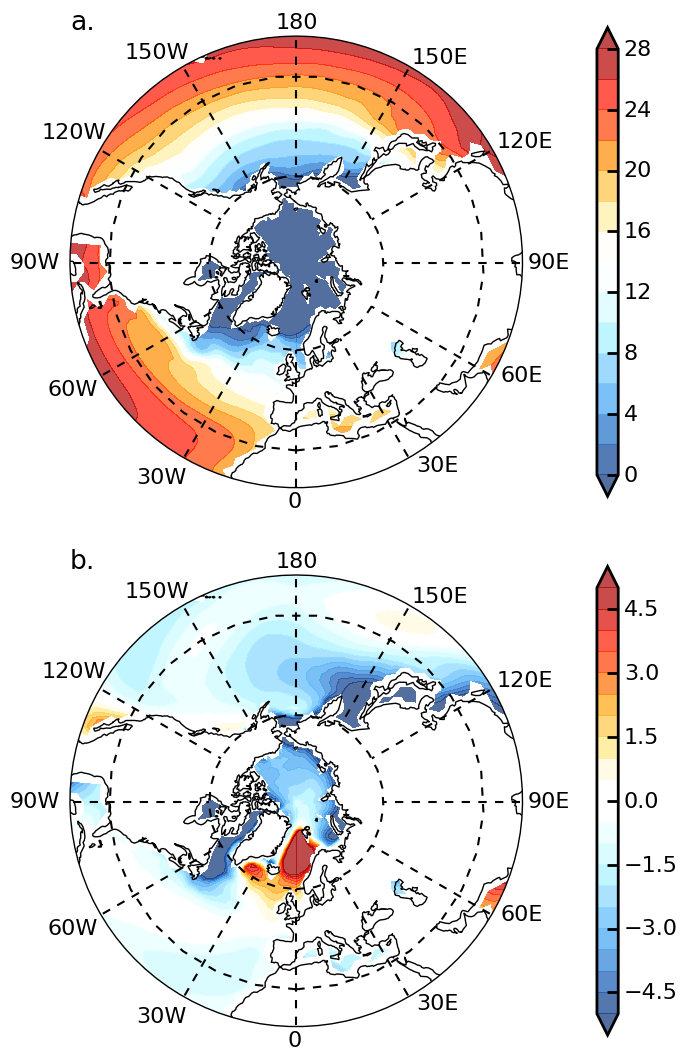

In [125]:
#SSTs CTL and diffs - FINAL

nrows = 2;ncols=1

matplotlib.rcParams['figure.figsize']=(8*ncols,6.5*nrows)
matplotlib.rcParams.update({'font.size':16})
plt.rcParams["axes.linewidth"]  = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
seas='DJF'

n=1

levels1 = np.arange(0,28.1,2.0)
levels2 = np.arange(-8,8.1,0.8)
levels3 = np.arange(-3,3.1,0.3)

levels1diffs = np.arange(-5,5.1,0.5)
levels2diffs = np.arange(-4,4.01,0.4)
levels3diffs = np.arange(-2,2.01,0.2)


fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.15)

# WACCM SOM

PS_M = (atmfields['WACCM_CTL_SOM']['DJF']['PS'].mean(dim='time')) 
PS_NM = (atmfields['WACCM_flat_SOM']['DJF']['PS'].mean(dim='time')) 


#toplotM_T = (atmfields['WACCM_CTL_SOM']['DJF']['SST'].mean(dim='time'))
#toplotNM_T = (atmfields['WACCM_flat_SOM']['DJF']['SST'].mean(dim='time'))

toplotM_T = (atmfields['WACCM_CTL_SOM']['DJF']['TS'].mean(dim='time')) - 273.15
toplotNM_T = (atmfields['WACCM_flat_SOM']['DJF']['TS'].mean(dim='time')) - 273.15


# CTL T850
ax = set_NPstereo(ncols,nrows,n); n+=1

toplot = toplotNM_T * landmask_WACCM
new_da = add_lon(toplot,coord='lon')

im = plt.contourf(new_da.lon, new_da.lat,new_da.values,transform=ccrs.PlateCarree(),
    levels=levels1,cmap=cmap_wc,extend='both',linestyles='--',alpha=0.7)

title = ('a.')
plt.title(title,loc='left')
plt.colorbar(pad=0.12)


#CTL - NM 

# T850
ax = set_NPstereo(ncols,nrows,n); n+=1

toplot = (toplotM_T - toplotNM_T) * landmask_WACCM
new_da = add_lon(toplot,coord='lon')

im = plt.contourf(new_da.lon, new_da.lat,new_da.values,transform=ccrs.PlateCarree(),
    levels=levels1diffs,cmap=cmap_wc,extend='both',linestyles='--',alpha=0.7)

title = ('b.')
plt.title(title,loc='left')
plt.colorbar(pad=0.12)

plt.savefig('/home/disk/eos4/rachel/Projects/StationaryWaves/FiguresJAS/Fig1SST.eps', dpi=None, facecolor='w', 
        edgecolor='w',
        orientation='portrait')

plt.show()

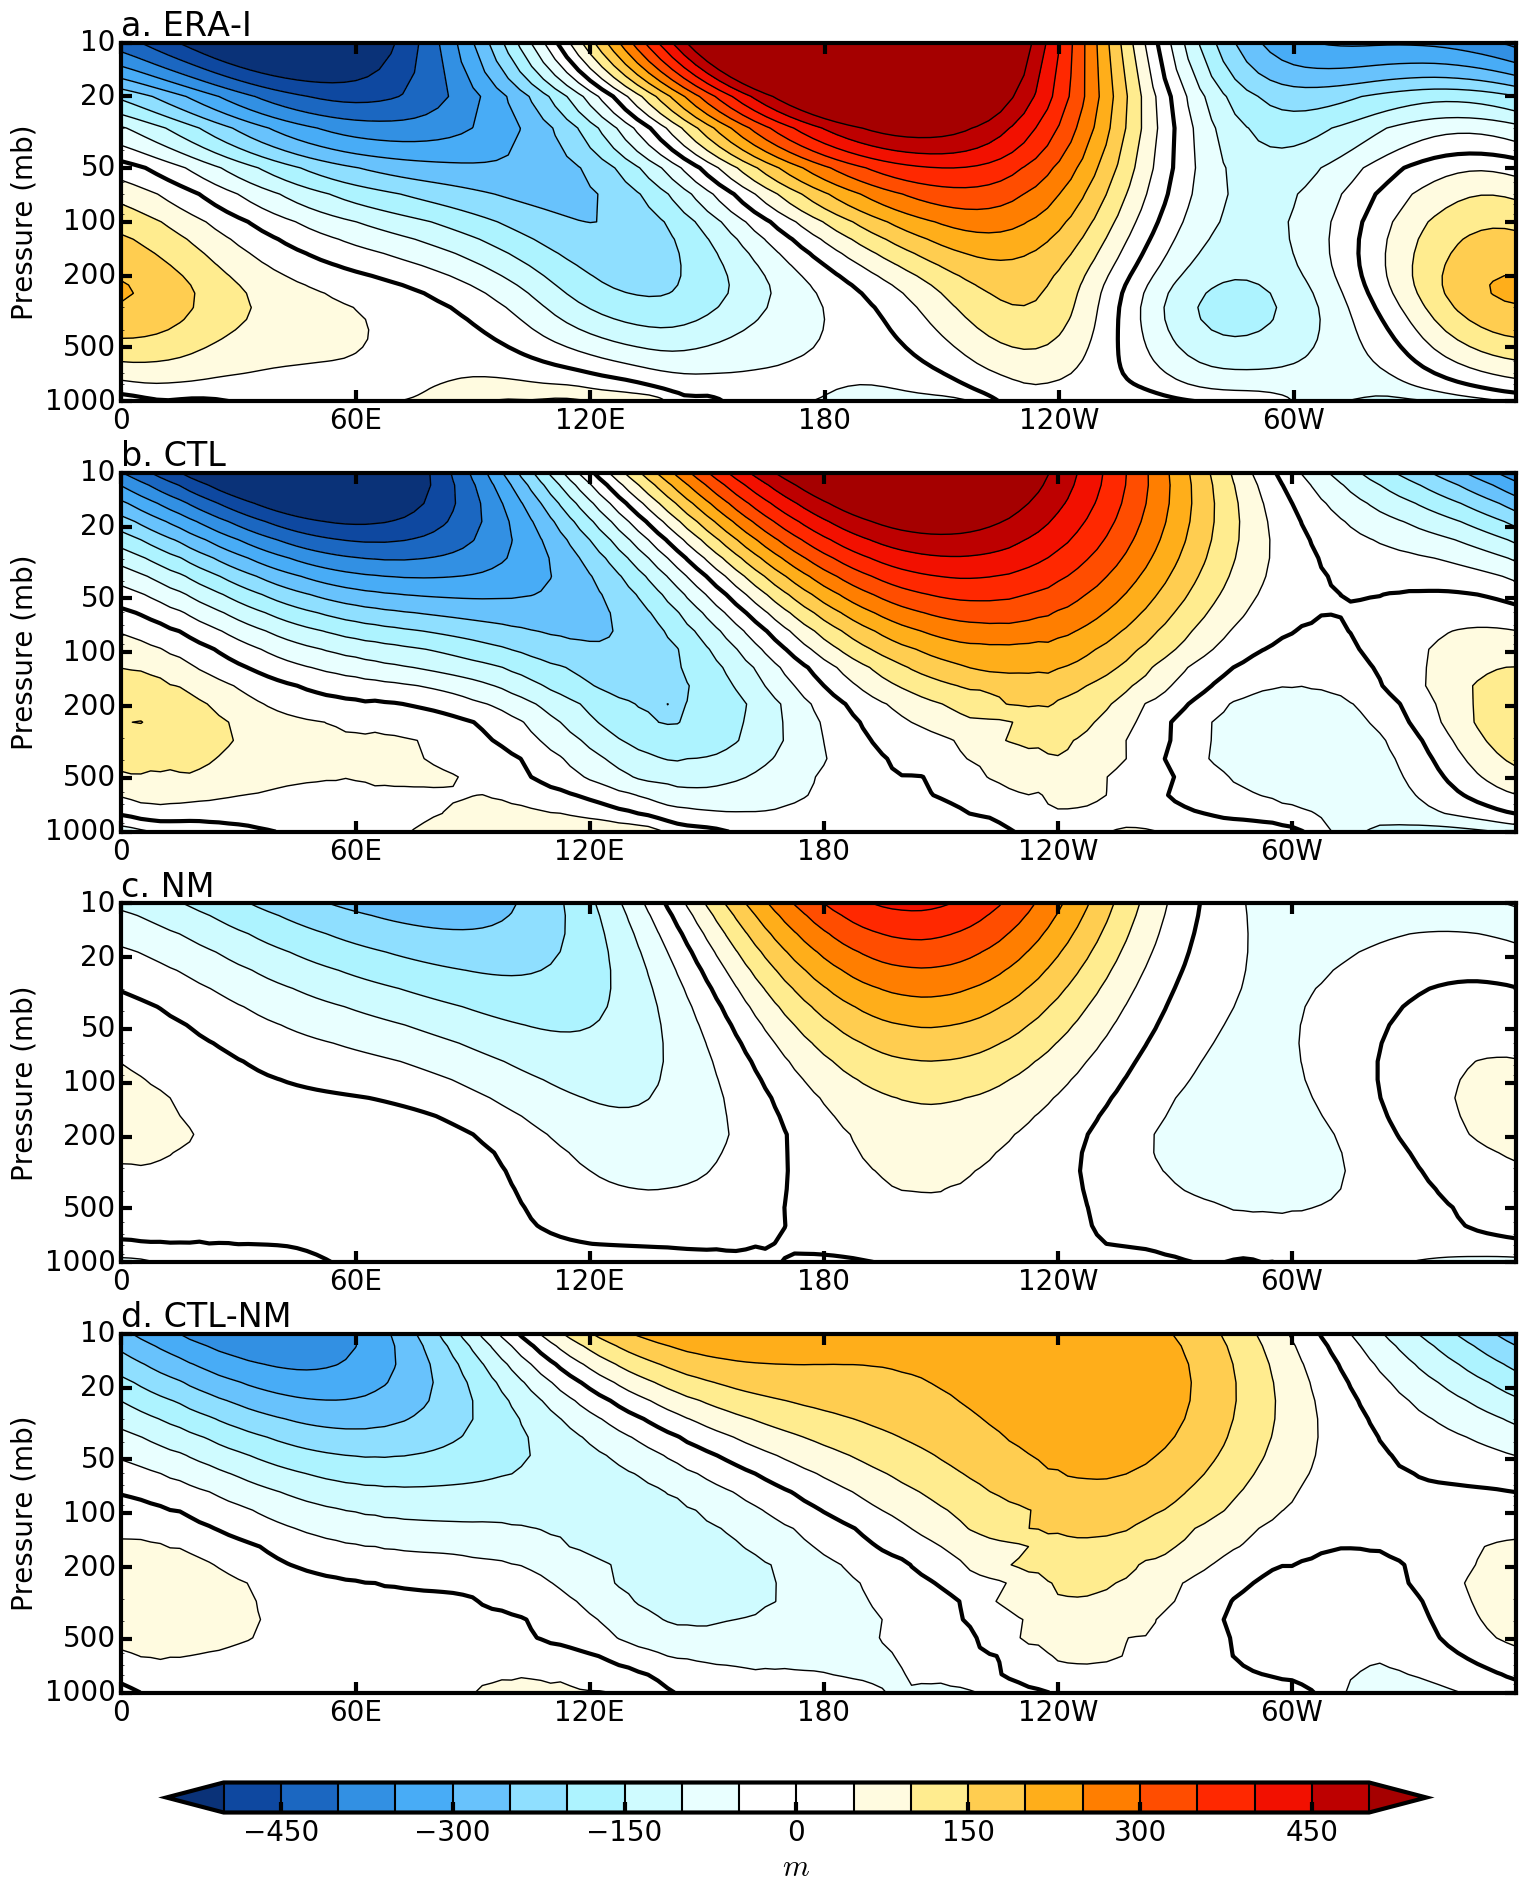

In [123]:
# plot cross-section Z at 60N, ERAI, Mountain vs Thermal
nrows = 4
matplotlib.rcParams['figure.figsize']=(18,5 * nrows)
matplotlib.rcParams.update({'font.size':20})
plt.rcParams["axes.linewidth"]  = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8

seas='DJF'
var='Z_logp'
Evar = 'var156'
lat = 60

ncols = 1
n=1

const = 1.0
ERAIconst = 1.0/9.81

levels1 = [-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300,350,400,450,500]
levels2 = [50,100,150,200,250,300,350,400]

vmin0 = -100; vmax0=100
vmin = -100; vmax = 100
cmap='bwr'
nlevels0 = 16
nlevels = 16
cenlon = 0

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
toplotM = (atmfields['pWACCM_CTL_SOM'][seas][var].sel(lat = lat,method='nearest')).mean(dim='time')
toplotNM = (atmfields['pWACCM_flat_SOM'][seas][var].sel(lat = lat,method='nearest')).mean(dim='time')

toplotERAI = ERAIconst * ERAI_3deg['z'].isel(time=0).sel(latitude = lat,method='nearest')
#ERAI['DJF']['z'].sel(latitude = lat,method='nearest')

#plot ERAI
ax = plt.subplot(nrows,ncols,n); n+=1
toplot = toplotERAI

toplot = toplot - toplot.mean(dim='longitude')
im = toplot.plot.contourf(
    levels=levels1,cmap=cmap_wc,extend='both',linestyles='--',add_colorbar = False)
toplot.plot.contour(
    levels=levels1,colors='k',extend='both',linestyles='-')
toplot.plot.contour(
    levels=[0],colors='k',extend='both',linestyles='-',linewidths=3.0)
title = ('a. ERA-I')
setaxes_lon(title,'')
plt.ylabel('Pressure (mb)')
plt.xlabel('')
plt.title('')



#plot WACCM
ax = plt.subplot(nrows,ncols,n); n+=1
toplot = toplotM

toplot = toplot - toplot.mean(dim='lon')
im = toplot.plot.contourf(
    levels=levels1,cmap=cmap_wc,extend='both',linestyles='--',add_colorbar = False)
toplot.plot.contour(
    levels=levels1,colors='k',extend='both',linestyles='-')
toplot.plot.contour(
    levels=[0],colors='k',extend='both',linestyles='-',linewidths=3.0)
title = ('b. CTL')
setaxes_lon(title,'')
plt.ylabel('Pressure (mb)')
plt.xlabel('')
plt.title('')

#plot WACCM
ax = plt.subplot(nrows,ncols,n); n+=1
toplot = toplotNM

toplot = toplot - toplot.mean(dim='lon')
im = toplot.plot.contourf(
    levels=levels1,cmap=cmap_wc,extend='both',linestyles='--',add_colorbar = False)
toplot.plot.contour(
    levels=levels1,colors='k',extend='both',linestyles='-')
toplot.plot.contour(
    levels=[0],colors='k',extend='both',linestyles='-',linewidths=3.0)
title = ('c. NM')
setaxes_lon(title,'')
plt.ylabel('Pressure (mb)')
plt.xlabel('')
plt.title('')


#plot WACCM
ax = plt.subplot(nrows,ncols,n); n+=1
toplot = toplotM - toplotNM

toplot = toplot - toplot.mean(dim='lon')
im = toplot.plot.contourf(
    levels=levels1,cmap=cmap_wc,extend='both',linestyles='--',add_colorbar = False)
toplot.plot.contour(
    levels=levels1,colors='k',extend='both',linestyles='-')
toplot.plot.contour(
    levels=[0],colors='k',extend='both',linestyles='-',linewidths=3.0)
title = ('d. CTL-NM')
setaxes_lon(title,'')
plt.ylabel('Pressure (mb)')
plt.xlabel('')
plt.title('')

fig.subplots_adjust(bottom=0.075)
cbar_ax = fig.add_axes([0.15, 0.015, 0.7, 0.015])
cbar_ax.tick_params(labelsize=20) 
cb = fig.colorbar(im,cax=cbar_ax,orientation='horizontal',drawedges=True)
cb.set_label(label = r'$m$',fontsize=22)

plt.savefig('/home/disk/eos4/rachel/Projects/StationaryWaves/FiguresJAS/Fig2Z_CS.eps', dpi=None, facecolor='w', 
        edgecolor='w',
        orientation='portrait')


plt.show()


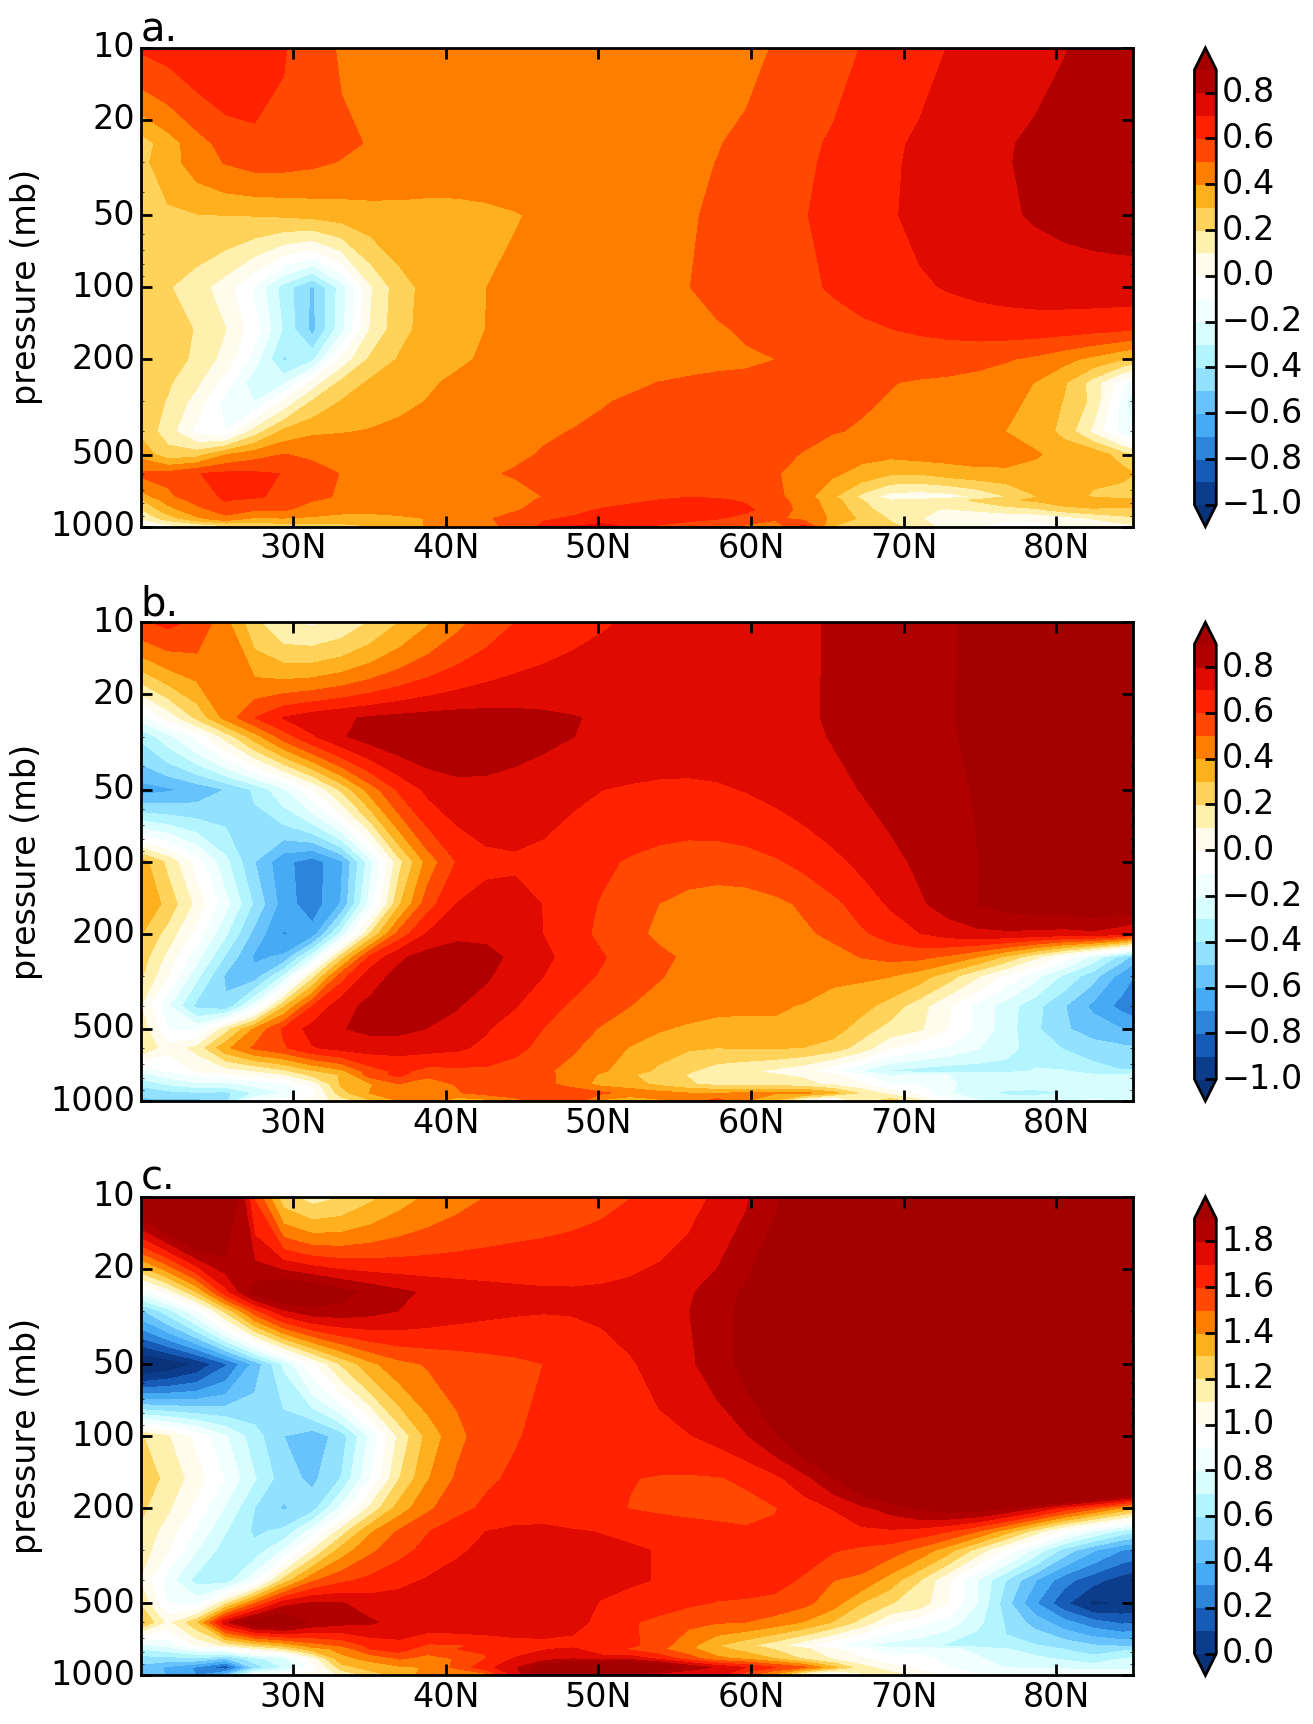

In [126]:
### Plot strength, correlation coefficient and amplitude
nrows = 3

matplotlib.rcParams['figure.figsize']=(16,7*nrows)
matplotlib.rcParams.update({'font.size':20})
plt.rcParams["axes.linewidth"]  = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8

exp1 = 'WACCM_CTL_SOM'
exp2 = 'WACCM_flat_SOM'

var = 'Z3'

lat1 = 10
lat2 = 90

varM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = varM.lat
try:
    levs = varM.lev_p
except AttributeError:
    levs = varM.lev_int
        

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_int = ilev),np.nan)
        
    try:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]
    varNM[ilev,:,:] = tempNM[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')


n=1

pt = 10

vmin0 = -100; vmax0=100
vmin = -100; vmax = 100
nlevels0 = 16
nlevels = 16
cenlon = 0
levelsC = np.arange(-1,1,0.1)

levelsA = np.arange(0,2.0,0.1)
#plot WACCM
# WACCM SOM
plt.subplot(nrows,1,n); n+=1

invarC_std = varM.std(dim='lon')
invarNM_std = varNM.std(dim='lon')
Mstrength = (invarC_std - invarNM_std)/invarC_std

plt.contourf(varM.lat, varM.lev_p,Mstrength.values,
    levels=levelsC,cmap=cmap_wc,extend='both')
plt.colorbar(extend='both')

setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('a.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')



## Correlation subplot

# Correlation Z3 for SOM
matplotlib.rcParams['figure.figsize']=(16,8)
matplotlib.rcParams.update({'font.size':24})

exp1 = 'WACCM_CTL_SOM'
exp2 = 'WACCM_flat_SOM'

var = 'Z3'

lat1 = 10
lat2 = 90

tempM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        
varM = tempM.copy(deep=True)

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')

corr_rs,corr_ps = pearson_regress_cs(varNM,varM)

plt.subplot(nrows,1,n); n+=1

plt.contourf(varM.lat, varM.lev_p,corr_rs.values,
    levels=levelsC,cmap=cmap_wc,extend='both')
plt.colorbar(extend='upper')

setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('b.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')


## Amplification subplot

# Calculate amplification factor

exp1 = 'WACCM_CTL_SOM'
exp2 = 'WACCM_flat_SOM'

var = 'Z3'

lat1 = 10
lat2 = 90

tempM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        
varM = tempM.copy(deep=True)

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')

amp_rs,amp_ps = amplification_factor(varNM,varM)


plt.subplot(nrows,1,n); n+=1

ps_mask = np.where(amp_ps < 0.01,np.nan,1.0)

plt.contourf(varM.lat, varM.lev_p,amp_rs.values,
    levels=levelsA,cmap=cmap_wc,extend='both')
plt.colorbar(extend='upper')

#plt.contourf(varM.lat, varM.lev_p,ps_mask,linecolors='white',
#    levels=[0,2],colors = 'none',hatches=['.'],extend='both')


setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('c.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')

plt.savefig('/home/disk/eos4/rachel/Projects/StationaryWaves/FiguresJAS/Fig3corr_amp.eps', dpi=None, facecolor='w', 
        edgecolor='w',
        orientation='portrait')

plt.show()

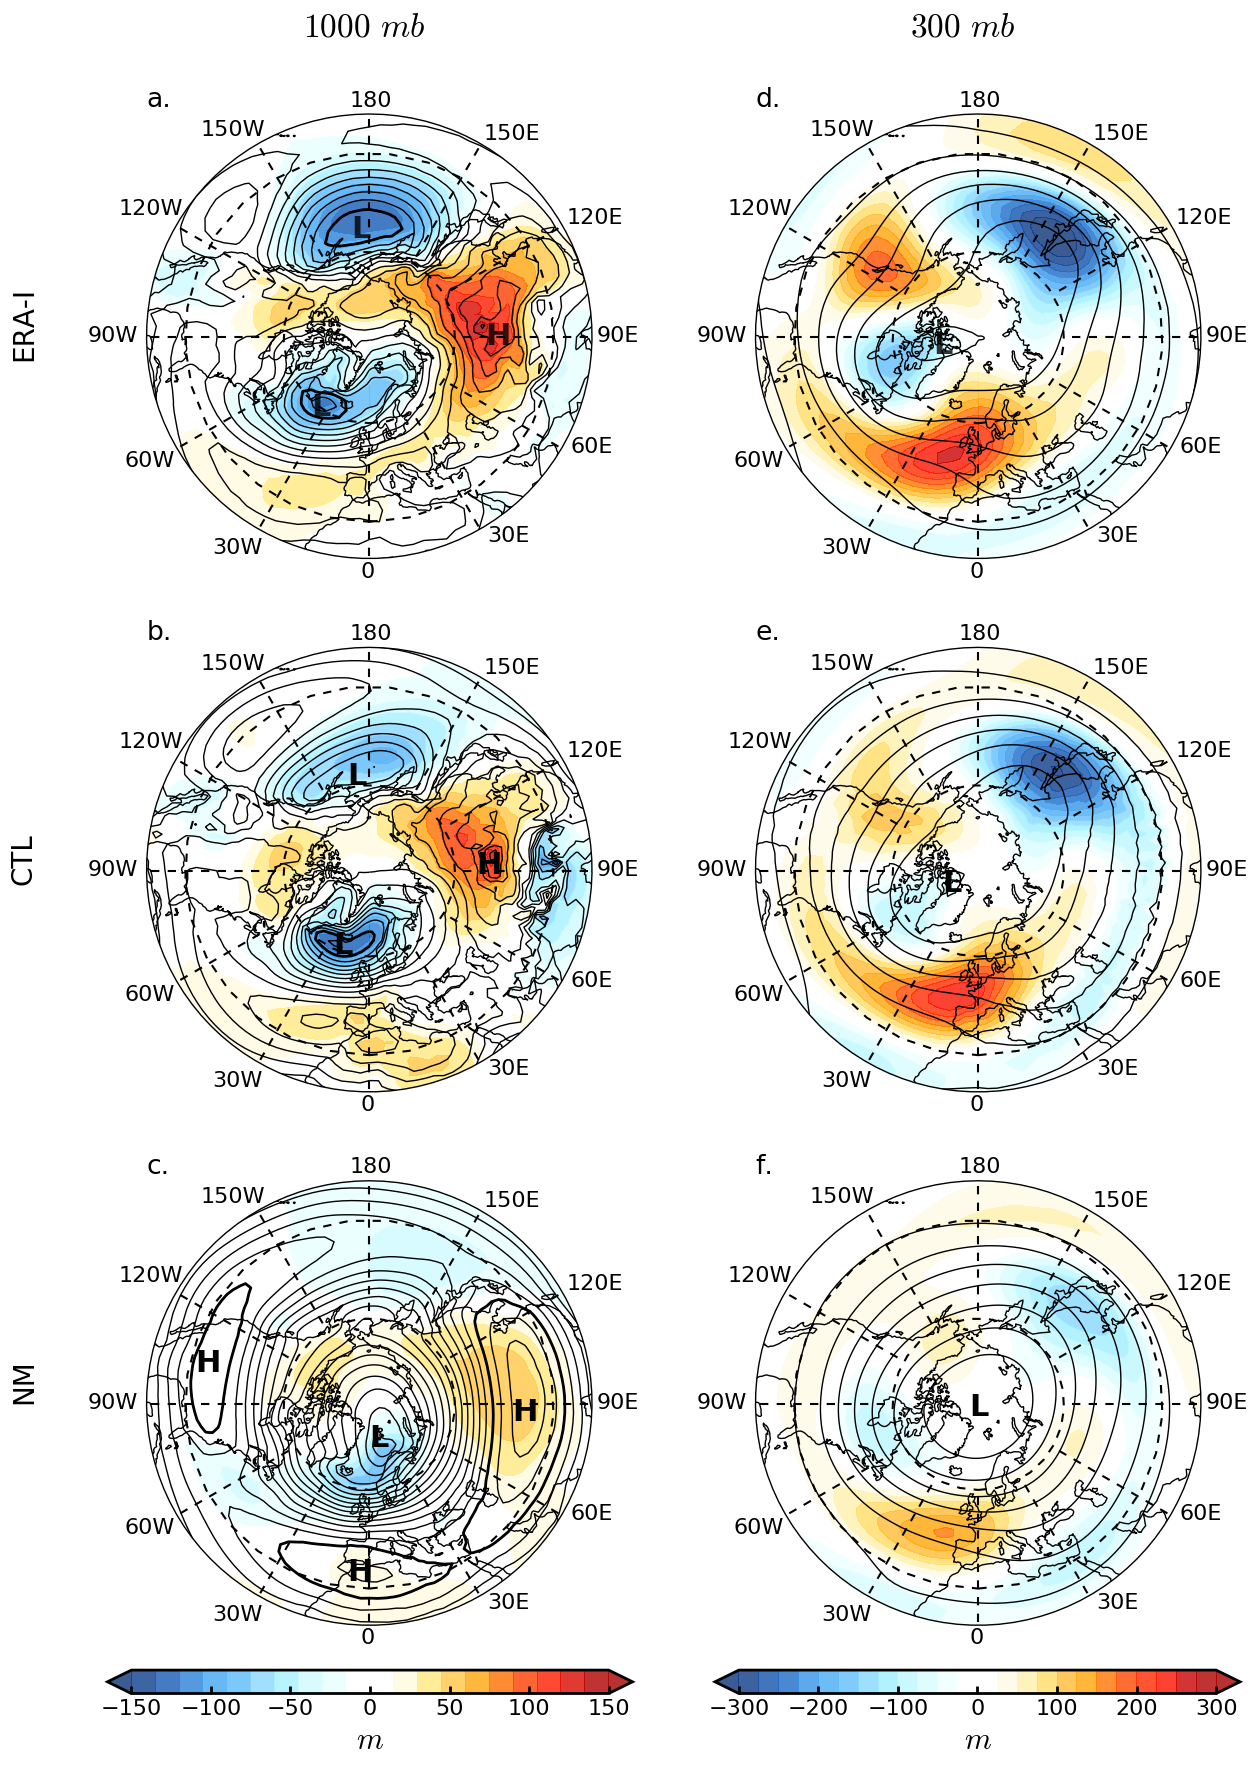

In [127]:
#Z300 and Z1000 WACCM SOM ERA, CTL, and CTL-NM 
nrows=3
matplotlib.rcParams['figure.figsize']=(15,6.5*nrows)
matplotlib.rcParams.update({'font.size':16})
plt.rcParams["axes.linewidth"]  = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6

from cartopy.util import add_cyclic_point

seas='DJF'
var='Z3'

n=1

fig, axes = plt.subplots(nrows=nrows, ncols=2)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.2)

vmin0 = 990; vmax0=1035
vmin = -100; vmax = 100
cmap='bwr'
nlevels0 = 16
nlevels = 16
cenlon = 0
const = 0.01
ERAIconst = 1.0/9.81
#plotCTL(seas,var,vmin=vmin0,vmax=vmax0)

font0 = FontProperties()
font0.set_weight('bold')
n=1
o=3
p=5

labeln = 0
labels = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.']

n=1
for plev,vbar in [(1000,0.185),(300,0.59)]:

    # plotting:
    toplotE = ERAIconst * ERAI_3deg['z'].isel(time=0).sel(level=plev)
            #ERAI['DJF']['z' + str(plev)]
        
    toplotM = atmfields['pWACCM_CTL_SOM']['DJF']['Z3'].sel(lev_p=plev).mean(dim='time')
    toplotNM = atmfields['pWACCM_flat_SOM']['DJF']['Z3'].sel(lev_p=plev).mean(dim='time')


    if plev == 1000:
        levels1 = np.arange(-500,500.1,20.0)

        levels2 = np.arange(-150,150.1,15)      
    elif plev == 300:
        levels1 = np.arange(4000,12001,200)

        levels2 = np.arange(-300,301,25)
        
    # ERAI
    toplot = toplotE
    name = 'ERA-I'
    
    ax = set_NPstereo(2,nrows,n); n+=1

    toplot2 = toplot - toplot.mean(dim='longitude')

    new_da = add_lon(toplot,coord='longitude')
    new_da2 = add_lon(toplot2,coord='longitude')
   
    plt.contour(new_da.longitude, new_da.latitude,new_da.values,transform=ccrs.PlateCarree(),
            levels=levels1,colors='k',extend='both',linestyles='-') 
    # bold zero contour
    plt.contour(new_da.longitude, new_da.latitude,new_da.values,transform=ccrs.PlateCarree(),
            levels=[0],colors='k',extend='both',linewidths=2)  

    im = plt.contourf(new_da2.longitude, new_da2.latitude,new_da2.values,transform=ccrs.PlateCarree(),
        levels=levels2,cmap=cmap_wc,extend='both',alpha=0.8)
    
    plt.title(labels[labeln],loc='left'); labeln +=1
              
        
    # Draw H's and L's in fixed locations
    if plev == 300:
        plt.text(0.40,0.46,'L',fontsize = 22,transform=ax.transAxes,fontproperties=font0,alpha=0.8)

    elif plev == 1000:
        plt.text(0.37,0.32,'L',fontsize = 22,transform=ax.transAxes,fontproperties=font0,alpha=0.8)
        plt.text(0.46,0.72,'L',fontsize = 22,transform=ax.transAxes,fontproperties=font0,alpha=0.8)
        plt.text(0.76,0.48,'H',fontsize = 22,transform=ax.transAxes,fontproperties=font0,alpha=0.8)

        
    ax = set_NPstereo(2,nrows,o); o+=1
    
    toplot = toplotM
    name = 'CTL'

    toplot2 = toplot - toplot.mean(dim='lon')

    new_da = add_lon(toplot,coord='lon')
    new_da2 = add_lon(toplot2,coord='lon')
  
    plt.contour(new_da.lon, new_da.lat,new_da.values,transform=ccrs.PlateCarree(),
           levels=levels1,colors='k',extend='both',linestyles='-') 
    # bold zero contour
    plt.contour(new_da.lon, new_da.lat,new_da.values,transform=ccrs.PlateCarree(),
            levels=[0],colors='k',extend='both',linewidths=2)  

    im = plt.contourf(new_da2.lon, new_da2.lat,new_da2.values,transform=ccrs.PlateCarree(),
        levels=levels2,cmap=cmap_wc,extend='both',alpha=0.8)
    
    plt.title(labels[labeln],loc='left'); labeln +=1

    #plt.title(labels[labeln] + ' A = ' + '{:02.2f}'.format(float(latsum.values)),
    #                                                      loc='left'); labeln+=1

    # Draw H's and L's in fixed locations
    if plev == 300:
        plt.text(0.42,0.45,'L',fontsize = 22,transform=ax.transAxes,fontproperties=font0)

    elif plev == 1000:
        plt.text(0.42,0.31,'L',fontsize = 22,transform=ax.transAxes,fontproperties=font0)
        plt.text(0.45,0.69,'L',fontsize = 22,transform=ax.transAxes,fontproperties=font0)
        plt.text(0.74,0.49,'H',fontsize = 22,transform=ax.transAxes,fontproperties=font0)

    ax = set_NPstereo(2,nrows,p); p+=1
    
    toplot = toplotNM
    name = 'NM'

    toplot2 = toplot - toplot.mean(dim='lon')

    new_da = add_lon(toplot,coord='lon')
    new_da2 = add_lon(toplot2,coord='lon')
  
    plt.contour(new_da.lon, new_da.lat,new_da.values,transform=ccrs.PlateCarree(),
           levels=levels1,colors='k',extend='both',linestyles='-') 
    # bold zero contour
    plt.contour(new_da.lon, new_da.lat,new_da.values,transform=ccrs.PlateCarree(),
            levels=[0],colors='k',extend='both',linewidths=2)  

    im = plt.contourf(new_da2.lon, new_da2.lat,new_da2.values,transform=ccrs.PlateCarree(),
        levels=levels2,cmap=cmap_wc,extend='both',alpha=0.8)
    
    plt.title(labels[labeln],loc='left'); labeln +=1
              

    title = (name)
    if plev == 1000:
        fig.text(0.07,0.8,'ERA-I',fontsize=20,rotation=90)
        fig.text(0.07,0.52,'CTL',fontsize=20,rotation=90)
        fig.text(0.07,0.25,'NM',fontsize=20,rotation=90)

    #plt.title(labels[labeln] + ' A = ' + '{:02.2f}'.format(float(latsum.values)),
    #                                                      loc='left'); labeln+=1

    # Draw H's and L's in fixed locations
    if plev == 300:
        plt.text(0.48,0.47,'L',fontsize = 22,transform=ax.transAxes,fontproperties=font0)

    elif plev == 1000:
        plt.text(0.5,0.40,'L',fontsize = 22,transform=ax.transAxes,fontproperties=font0)
        plt.text(0.82,0.46,'H',fontsize = 22,transform=ax.transAxes,fontproperties=font0)
        plt.text(0.45,0.10,'H',fontsize = 22,transform=ax.transAxes,fontproperties=font0)
        plt.text(0.11,0.57,'H',fontsize = 22,transform=ax.transAxes,fontproperties=font0)

    if plev == 300:
        ticks = [-300,-200,-100,0,100,200,300]
    elif plev == 850:
        ticks = [-150,-100,-50,0,50,100,150]
    elif plev == 1000:
        ticks = [-150,-100,-50,0,50,100,150]        
    cbar_ax = fig.add_axes([vbar -0.05, 0.09, 0.35, 0.012])
    cbar_ax.tick_params(labelsize=16) 
    cb = fig.colorbar(im,cax=cbar_ax,orientation='horizontal',ticks=ticks)
    cb.set_label(label = r'$m$',fontsize=22)
    fig.text(vbar+0.08,0.94,r'$' + str(plev) + '$ $mb$',rotation=0,fontsize=24)

plt.savefig('/home/disk/eos4/rachel/Projects/StationaryWaves/FiguresJAS/Fig4Zmaps.eps', dpi=None, facecolor='w', 
        edgecolor='w',
        orientation='portrait')

plt.show()

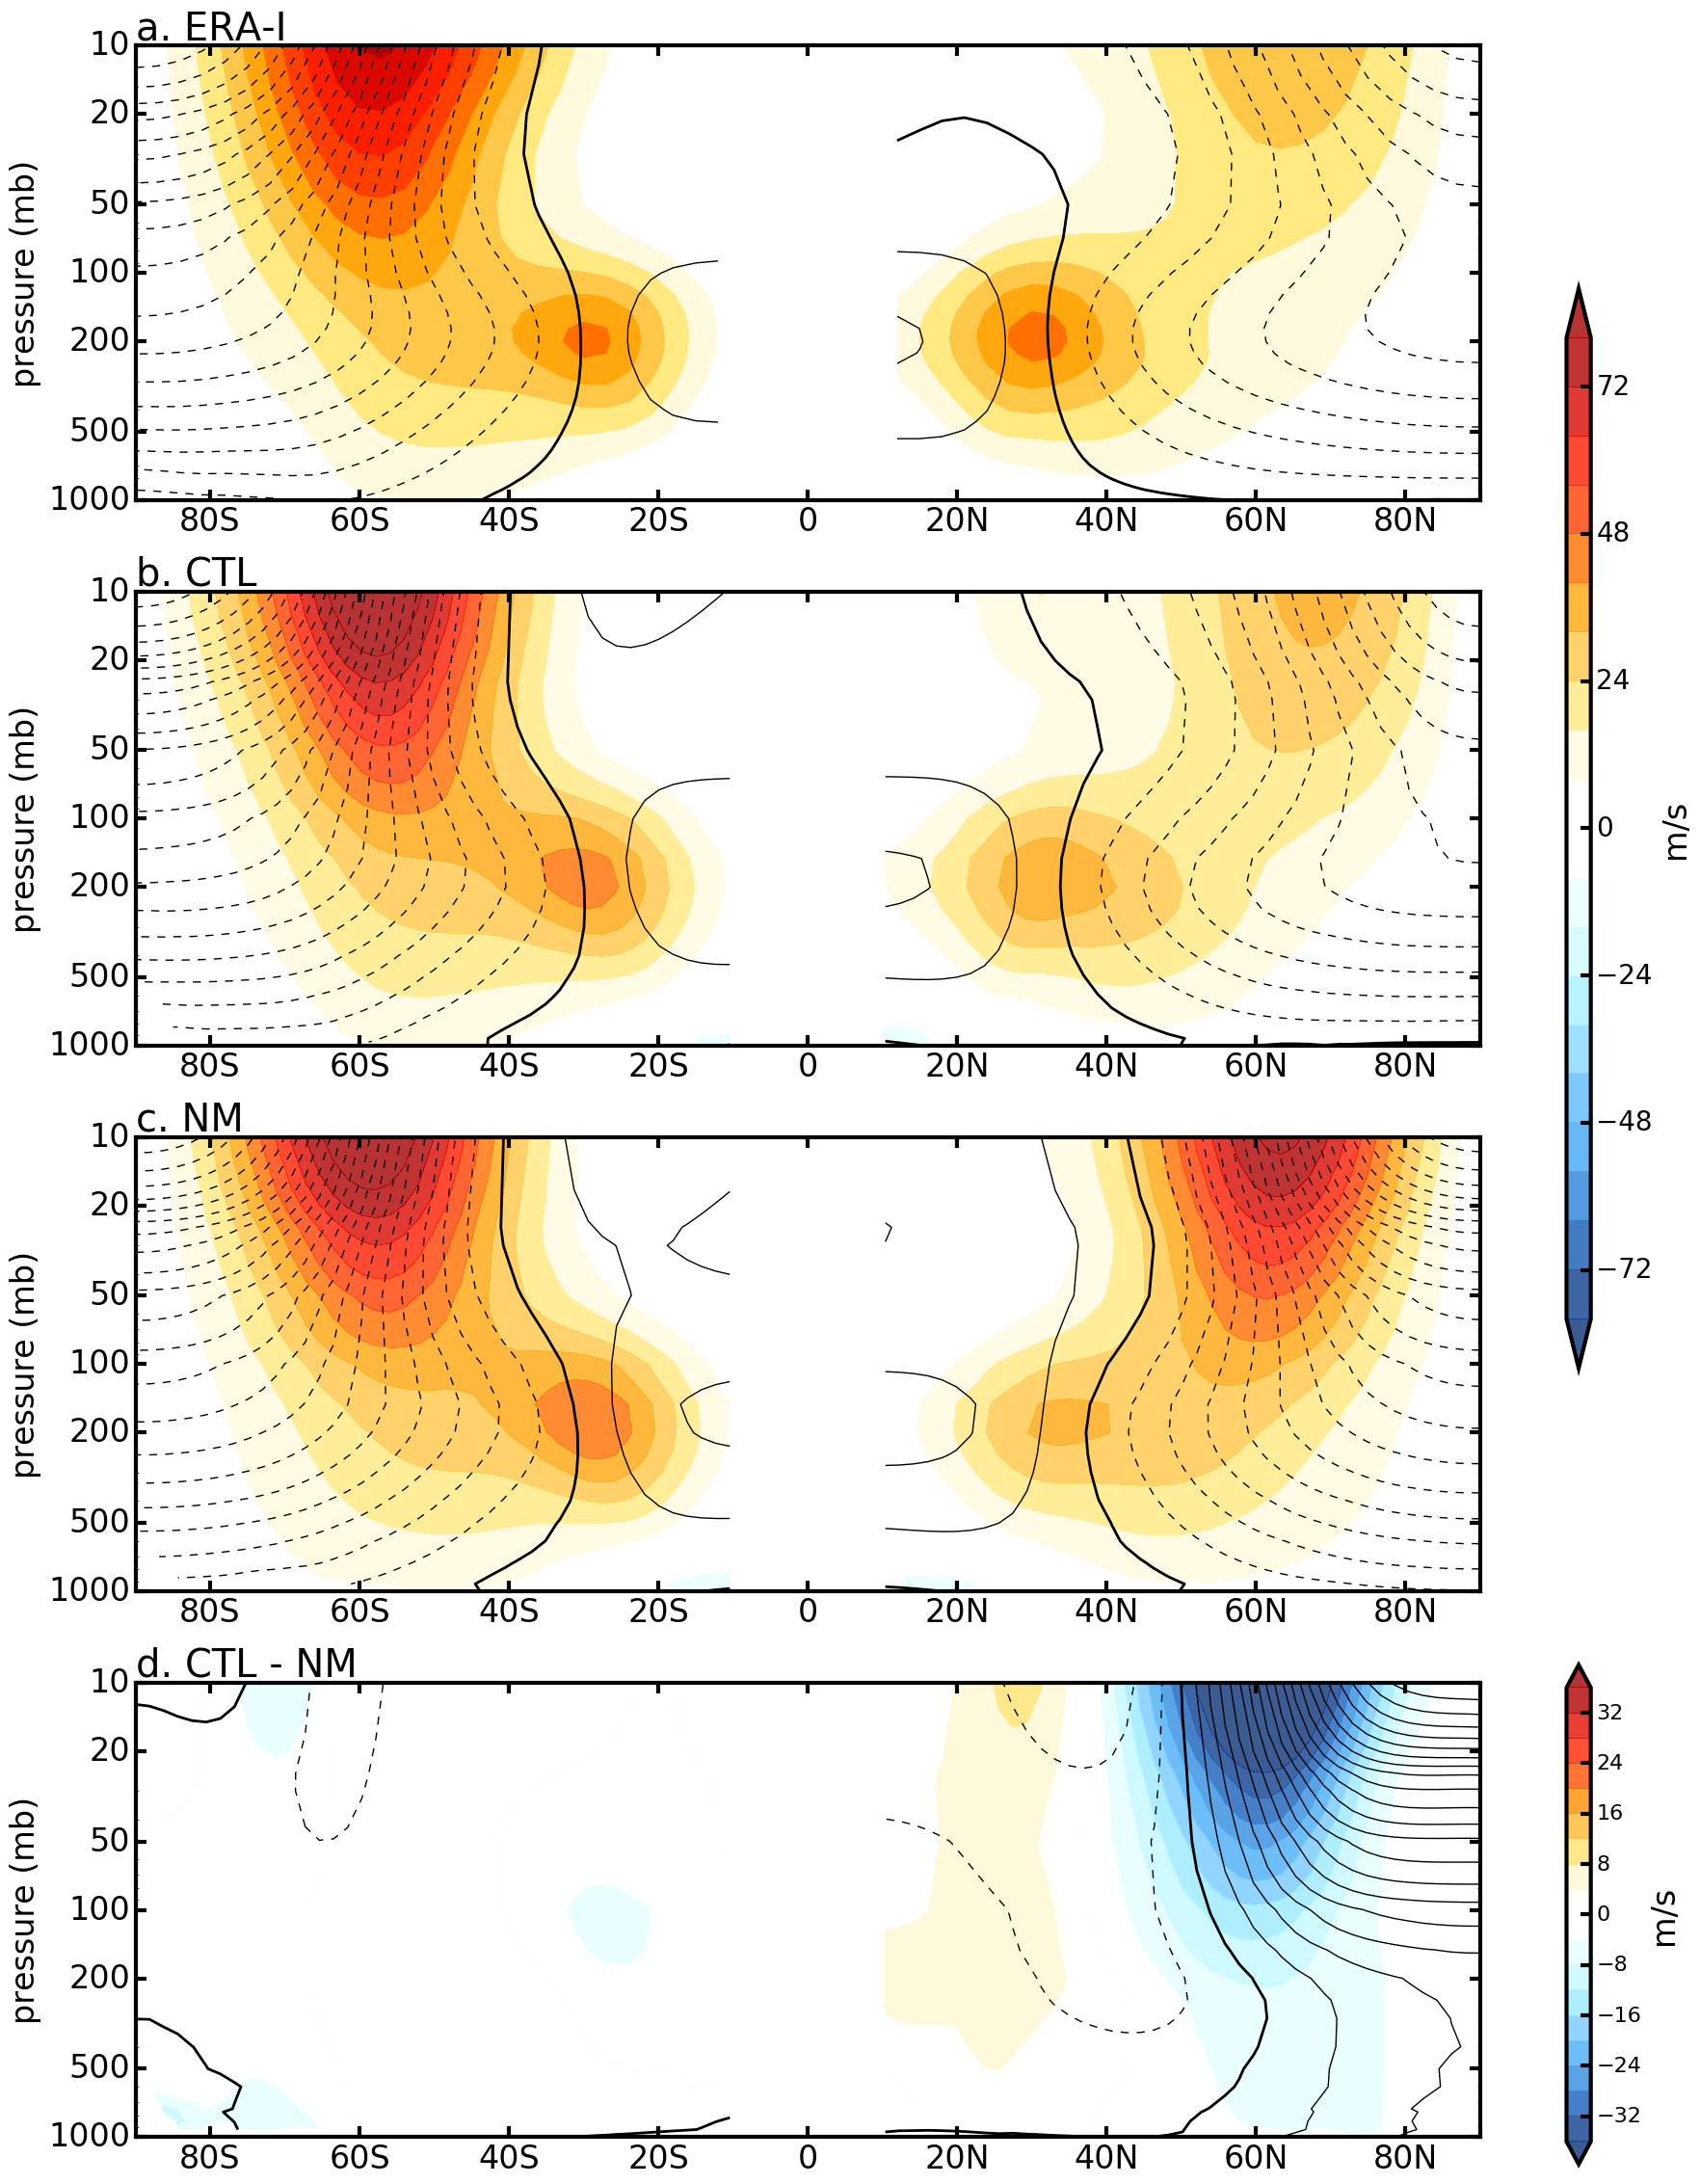

In [128]:
# Plot Z and U pole to pole

nrows = 4; n=1
ncols = 1
pt=10
matplotlib.rcParams['figure.figsize']=(18,7*nrows)
matplotlib.rcParams.update({'font.size':24})
plt.rcParams["axes.linewidth"]  = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8

const = 1.0

var1 = 'Z3'

ZtoplotE = ERAIconst * ERAI_3deg['z'].isel(time=0)
ZSHtoplotE = ERAIconst * ERAI_3deg['z'].isel(time=2)

ZtoplotM = const * atmfields['pWACCM_CTL_SOM'][seas][var1].mean(dim='time')
ZtoplotNM = const * atmfields['pWACCM_flat_SOM'][seas][var1].mean(dim='time')

ZSHtoplotM = const * atmfields['pWACCM_CTL_SOM']['JJA'][var1].mean(dim='time')
ZSHtoplotNM = const * atmfields['pWACCM_flat_SOM']['JJA'][var1].mean(dim='time')


var2 = 'U'
UtoplotE = 1.0 * ERAI_3deg['u'].isel(time=0)
USHtoplotE = 1.0 * ERAI_3deg['u'].isel(time=2)

UtoplotM = const * atmfields['pWACCM_CTL_SOM'][seas][var2].mean(dim='time')
UtoplotNM = const * atmfields['pWACCM_flat_SOM'][seas][var2].mean(dim='time')

USHtoplotM = const * atmfields['pWACCM_CTL_SOM']['JJA'][var2].mean(dim='time')
USHtoplotNM = const * atmfields['pWACCM_flat_SOM']['JJA'][var2].mean(dim='time')


PStoplot = atmfields['WACCM_CTL_SOM'][seas]['PS'].mean(dim='time')

# mask where below ground
nlevs = len(ZtoplotM.lev_p)
for ilev in range(0,nlevs):
    plev = ZtoplotM.lev_p[ilev]
    ZtoplotM[ilev,...] = np.where(PStoplot[...]/100. < plev,np.nan,ZtoplotM[ilev,...])
    ZtoplotNM[ilev,...] = np.where(PStoplot[...]/100. < plev,np.nan,ZtoplotNM[ilev,...])
    
    UtoplotM[ilev,...] = np.where(PStoplot[...]/100. < plev,np.nan,UtoplotM[ilev,...])
    UtoplotNM[ilev,...] = np.where(PStoplot[...]/100. < plev,np.nan,UtoplotNM[ilev,...])

    ZSHtoplotM[ilev,...] = np.where(PStoplot[...]/100. < plev,np.nan,ZSHtoplotM[ilev,...])
    ZSHtoplotNM[ilev,...] = np.where(PStoplot[...]/100. < plev,np.nan,ZSHtoplotNM[ilev,...])
    
    USHtoplotM[ilev,...] = np.where(PStoplot[...]/100. < plev,np.nan,USHtoplotM[ilev,...])
    USHtoplotNM[ilev,...] = np.where(PStoplot[...]/100. < plev,np.nan,USHtoplotNM[ilev,...])

    
# zonal mean
ZtoplotE = ZtoplotE.mean(dim='longitude')
UtoplotE = UtoplotE.mean(dim='longitude')

ZSHtoplotE = ZSHtoplotE.mean(dim='longitude')
USHtoplotE = USHtoplotE.mean(dim='longitude')


ZtoplotM = ZtoplotM.mean(dim='lon')
ZtoplotNM = ZtoplotNM.mean(dim='lon')
UtoplotM = UtoplotM.mean(dim='lon')
UtoplotNM = UtoplotNM.mean(dim='lon')

ZSHtoplotM = ZSHtoplotM.mean(dim='lon')
ZSHtoplotNM = ZSHtoplotNM.mean(dim='lon')
USHtoplotM = USHtoplotM.mean(dim='lon')
USHtoplotNM = USHtoplotNM.mean(dim='lon')


# calculate global mean Z for ERAI 
#latitude weighted global mean Z3
coslat = np.cos(np.deg2rad(ZtoplotE.latitude))
ZgmE = (ZtoplotE *coslat).sum(dim='latitude')/(coslat.sum(dim='latitude'))
ZSHgmE = (ZSHtoplotE *coslat).sum(dim='latitude')/(coslat.sum(dim='latitude'))

# subtract global mean from Z
ZtoplotE = ZtoplotE - ZgmE
ZSHtoplotE = ZSHtoplotE - ZSHgmE

# Repeat for WACCM
# latitude weighted global mean Z3
coslat = np.cos(np.deg2rad(ZtoplotM.lat))
ZgmM = (ZtoplotM *coslat).sum(dim='lat')/(coslat.sum(dim='lat'))
ZgmNM = (ZtoplotNM *coslat).sum(dim='lat')/(coslat.sum(dim='lat'))
ZSHgmM = (ZSHtoplotM *coslat).sum(dim='lat')/(coslat.sum(dim='lat'))
ZSHgmNM = (ZSHtoplotNM *coslat).sum(dim='lat')/(coslat.sum(dim='lat'))

# subtract global mean from Z
ZtoplotM = ZtoplotM - ZgmM
ZtoplotNM = ZtoplotNM - ZgmNM

ZSHtoplotM = ZSHtoplotM - ZSHgmM
ZSHtoplotNM = ZSHtoplotNM - ZSHgmNM

levelsZ = np.arange(-6000,6001,200)
levelsU = np.arange(-80,81,8)


# ERAI#
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

plt.subplot(nrows,1,n); n+=1

title = ('a. ERA-I')

toplotNH = ZtoplotE
toplotSH = ZSHtoplotE

toplotNH.values = np.where(toplotNH.latitude<10,np.nan,toplotNH.values)
toplotSH.values = np.where(toplotSH.latitude>-10,np.nan,toplotSH.values)


plt.contour(toplotNH.latitude, toplotNH.level,toplotNH.values,
    levels=levelsZ,colors = 'k')
plt.contour(toplotNH.latitude, toplotNH.level,toplotNH.values,
    levels=[0],colors = 'k',linewidths=2)

plt.contour(toplotSH.latitude, toplotSH.level,toplotSH.values,
    levels=levelsZ,colors = 'k')
plt.contour(toplotSH.latitude, toplotSH.level,toplotSH.values,
    levels=[0],colors = 'k',linewidths=2)

toplotNH = UtoplotE
toplotSH = USHtoplotE

toplotNH.values = np.where(toplotNH.latitude<10,np.nan,toplotNH.values)
toplotSH.values = np.where(toplotSH.latitude>-10,np.nan,toplotSH.values)

plt.contourf(toplotNH.latitude, toplotNH.level,toplotNH.values,
    levels=levelsU,cmap=cmap_wc,extend='both',linestyles='-')

plt.contourf(toplotSH.latitude, toplotSH.level,toplotSH.values,
    levels=levelsU,cmap=cmap_wc,extend='both',linestyles='-')

#plt.colorbar(label=r'$m/s$')

setaxes_latNS('','',ps=1000,pt=pt)    
plt.title(title,loc='left')

# WACCM SOM
plt.subplot(nrows,1,n); n+=1

title = ('b. CTL')

toplotNH = ZtoplotM
toplotSH = ZSHtoplotM

toplotNH.values = np.where(toplotNH.lat<10,np.nan,toplotNH.values)
toplotSH.values = np.where(toplotSH.lat>-10,np.nan,toplotSH.values)

plt.contour(toplotNH.lat, toplotNH.lev_p,toplotNH.values,
    levels=levelsZ,colors = 'k')
plt.contour(toplotNH.lat, toplotNH.lev_p,toplotNH.values,
    levels=[0],colors = 'k',linewidths=2)

plt.contour(toplotSH.lat, toplotSH.lev_p,toplotSH.values,
    levels=levelsZ,colors = 'k')
plt.contour(toplotSH.lat, toplotSH.lev_p,toplotSH.values,
    levels=[0],colors = 'k',linewidths=2)

toplotNH = UtoplotM
toplotSH = USHtoplotM

toplotNH.values = np.where(toplotNH.lat<10,np.nan,toplotNH.values)
toplotSH.values = np.where(toplotSH.lat>-10,np.nan,toplotSH.values)

plt.contourf(toplotNH.lat, toplotNH.lev_p,toplotNH.values,
    levels=levelsU,cmap=cmap_wc,extend='both',linestyles='-',alpha=0.8)
plt.contourf(toplotSH.lat, toplotSH.lev_p,toplotSH.values,
    levels=levelsU,cmap=cmap_wc,extend='both',linestyles='-',alpha=0.8)
#plt.colorbar(label=r'$m/s$')

setaxes_latNS('','',ps=1000,pt=pt)    
plt.title(title,loc='left')


# WACCM SOM Flat
plt.subplot(nrows,1,n); n+=1

title = ('c. NM')

toplotNH = ZtoplotNM
toplotSH = ZSHtoplotNM


toplotNH.values = np.where(toplotNH.lat<10,np.nan,toplotNH.values)
toplotSH.values = np.where(toplotSH.lat>-10,np.nan,toplotSH.values)

plt.contour(toplotNH.lat, toplotNH.lev_p,toplotNH.values,
    levels=levelsZ,colors = 'k')
plt.contour(toplotNH.lat, toplotNH.lev_p,toplotNH.values,
    levels=[0],colors = 'k',linewidths=2)

plt.contour(toplotSH.lat, toplotSH.lev_p,toplotSH.values,
    levels=levelsZ,colors = 'k')
plt.contour(toplotSH.lat, toplotSH.lev_p,toplotSH.values,
    levels=[0],colors = 'k',linewidths=2)


toplotNH = UtoplotNM
toplotSH = USHtoplotNM

toplotNH.values = np.where(toplotNH.lat<10,np.nan,toplotNH.values)
toplotSH.values = np.where(toplotSH.lat>-10,np.nan,toplotSH.values)

plt.contourf(toplotNH.lat, toplotNH.lev_p,toplotNH.values,
    levels=levelsU,cmap=cmap_wc,extend='both',linestyles='-',alpha=0.8)
im = plt.contourf(toplotSH.lat, toplotSH.lev_p,toplotSH.values,
    levels=levelsU,cmap=cmap_wc,extend='both',linestyles='-',alpha=0.8)
#plt.colorbar(label=r'$m/s$')

setaxes_latNS('','',ps=1000,pt=pt)    
plt.title(title,loc='left')

cbar_ax = fig.add_axes([0.95, 0.41, 0.014, 0.4])
cbar_ax.tick_params(labelsize=20) 
cb = fig.colorbar(im,cax=cbar_ax,orientation='vertical',drawedges=False)
cb.set_label(label = 'm/s',fontsize=24)


levelsZ = np.arange(-3000,3001,100)
levelsU = np.arange(-36,36.1,4)

# plot
plt.subplot(nrows,1,n); n+=1
title = ('d. CTL - NM')

toplot = ZtoplotM - ZtoplotNM.values
toplotSH = ZSHtoplotM - ZSHtoplotNM.values

plt.contour(toplot.lat, toplot.lev_p,toplot.values,
    levels=levelsZ,colors = 'k')
plt.contour(toplot.lat, toplot.lev_p,toplot.values,
    levels=[0],colors = 'k',linewidths=2)
plt.contour(toplotSH.lat, toplotSH.lev_p,toplotSH.values,
    levels=levelsZ,colors = 'k')
plt.contour(toplotSH.lat, toplotSH.lev_p,toplotSH.values,
    levels=[0],colors = 'k',linewidths=2)

toplot = UtoplotM - UtoplotNM.values
toplotSH = USHtoplotM - USHtoplotNM.values

#plt.contourf(toplot.lat, toplot.lev_p,toplot.values,
#    levels=levelsU,cmap=cmap_wc,norm=colors.SymLogNorm(linthresh=2.0, linscale=0.3,
#                                              vmin=-40.0, vmax=40.0),extend='both',linestyles='-')
#im = plt.contourf(toplotSH.lat, toplotSH.lev_p,toplotSH.values,
#    levels=levelsU,cmap=cmap_wc,norm=colors.SymLogNorm(linthresh=2.0, linscale=0.3,
#                                              vmin=-40.0, vmax=40.0),extend='both',linestyles='-')

plt.contourf(toplot.lat, toplot.lev_p,toplot.values,
    levels=levelsU,cmap=cmap_wc,extend='both',alpha=0.8) #,norm=colors.SymLogNorm(linthresh=2.0, linscale=0.3,
                                 #             vmin=-40.0, vmax=40.0),extend='both',linestyles='-')
im = plt.contourf(toplotSH.lat, toplotSH.lev_p,toplotSH.values,
    levels=levelsU,cmap=cmap_wc,extend='both',alpha=0.8) #,norm=colors.SymLogNorm(linthresh=2.0, linscale=0.3,
                                 #             vmin=-40.0, vmax=40.0),extend='both',linestyles='-')


#plt.colorbar(label=r'$m/s$')
setaxes_latNS('','',ps=1000,pt=pt)    
plt.title(title,loc='left')
    
cbar_ax = fig.add_axes([0.95, 0.115, 0.014, 0.185])
cbar_ax.tick_params(labelsize=16) 
cb = fig.colorbar(im,cax=cbar_ax,orientation='vertical',drawedges=False)
cb.set_label(label = 'm/s',fontsize=24)
    
plt.savefig('/home/disk/eos4/rachel/Projects/StationaryWaves/FiguresJAS/Fig5U_ZM.eps', dpi=None, facecolor='w', 
        edgecolor='w',
        orientation='portrait')

plt.show() 


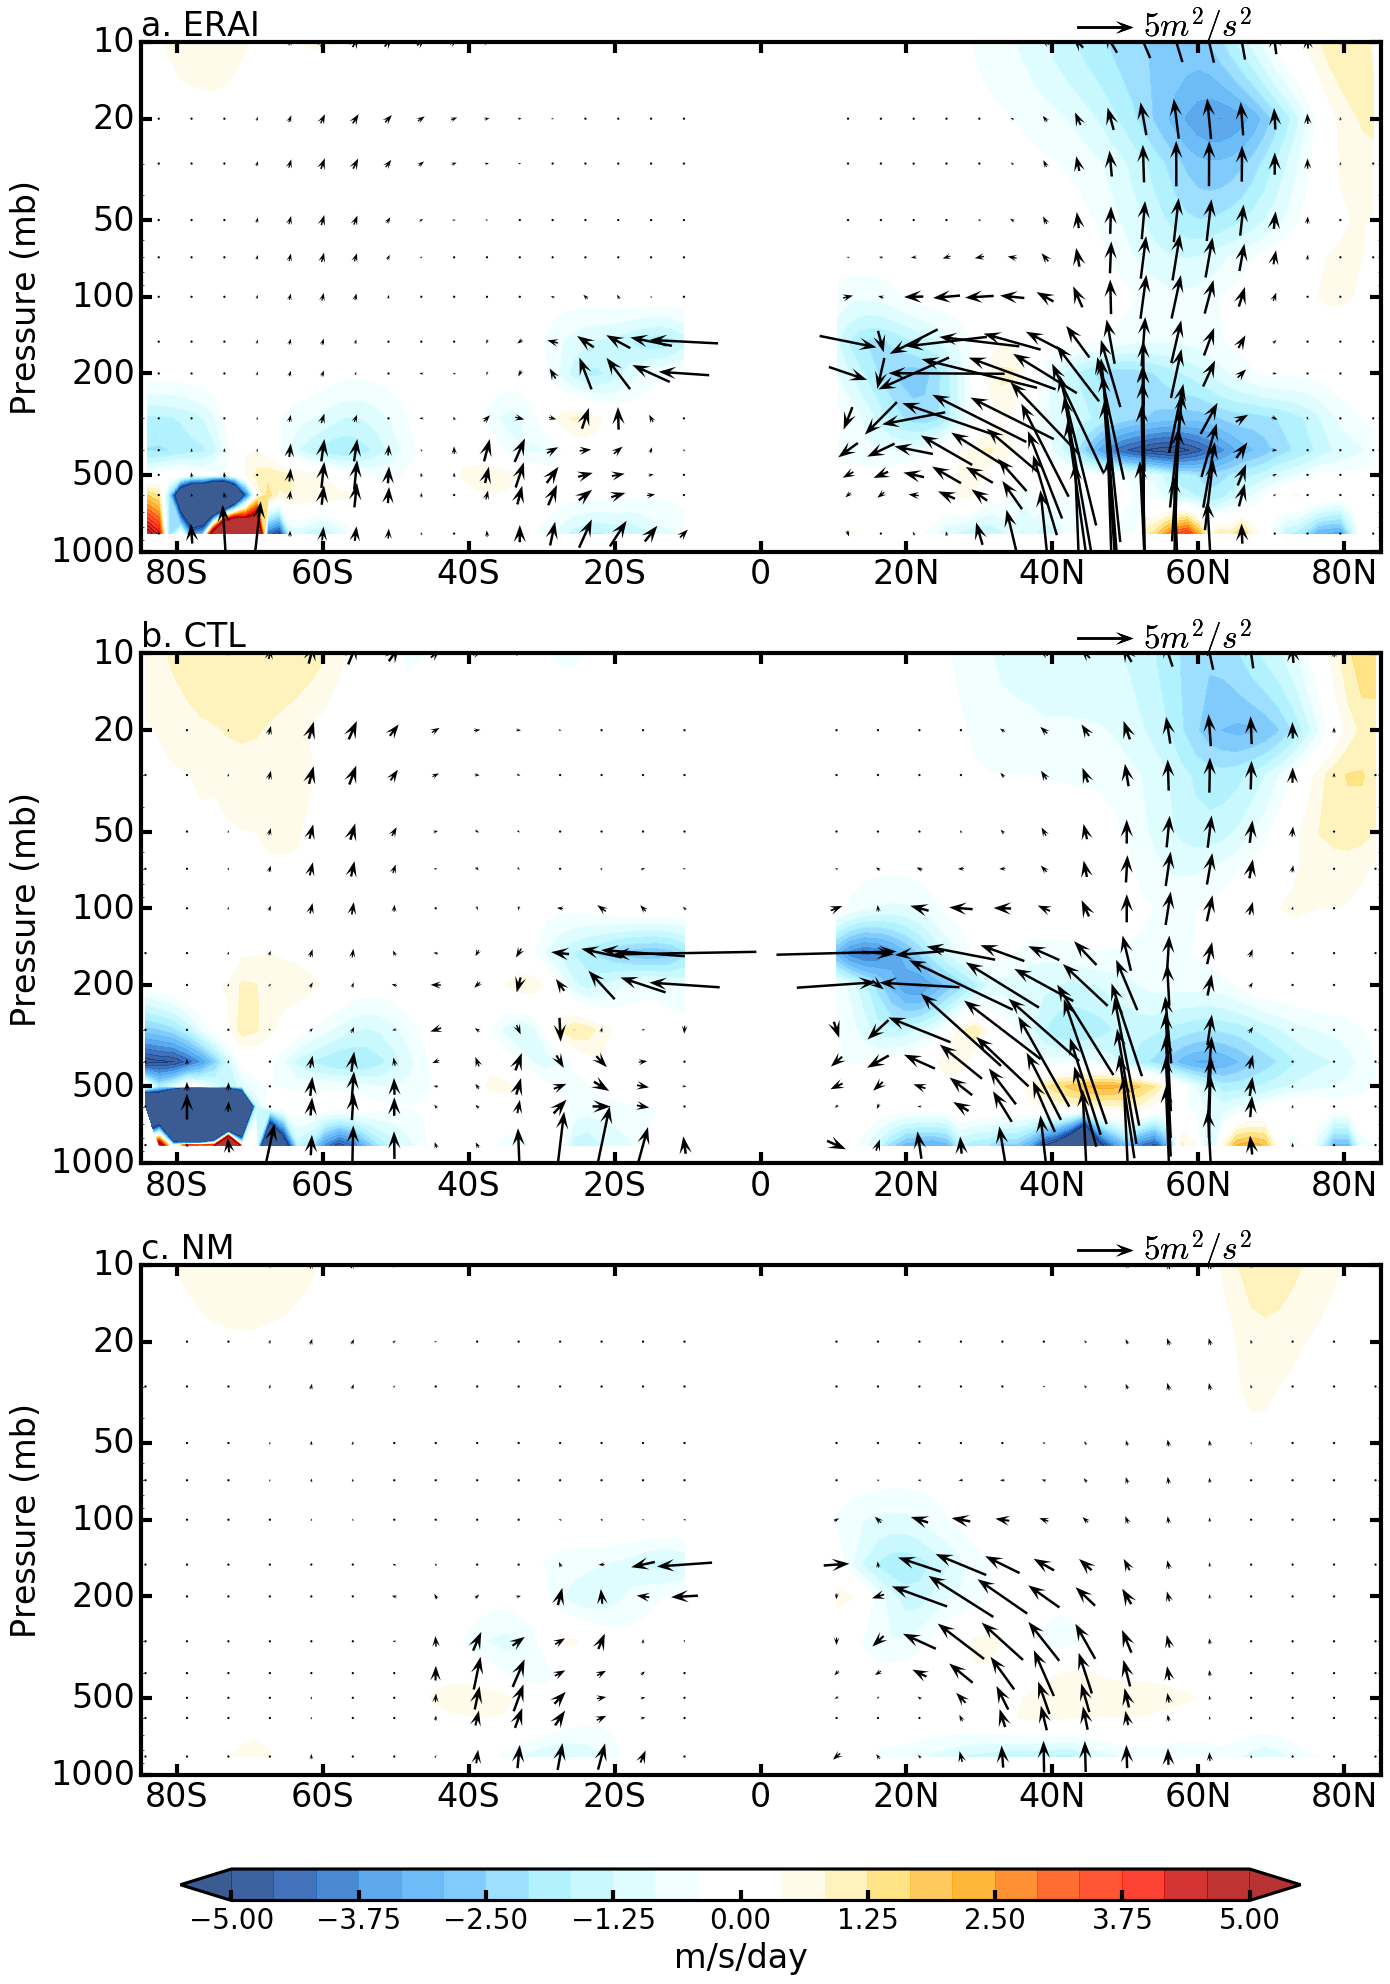

In [15]:
#Plot ERAI and WACCM CTL
nrows = 3; ncols = 1; n=1
matplotlib.rcParams['figure.figsize']=(16,7 * nrows)
matplotlib.rcParams.update({'font.size':24})
plt.rcParams["axes.linewidth"]  = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8

# plot EP and U
startlat = -85
endlat = 85
startp = 950
endp = 2

Pt = 10
Ps = 1000

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)


ax = plt.subplot(nrows,ncols,n); n+=1

levels = [850,600,500,400,300,200,150,100,70,50,30,20,10,7,5,3,2,1]

EP_CTL_NH = WACCM_EP_CTL['DJF'].sel(lat=slice(10,85)).sel(lev_int = levels)
EP_CTL_SH = WACCM_EP_CTL['JJA'].sel(lat=slice(-85,-10)).sel(lev_int = levels)


EP_NM_NH = WACCM_EP_NM['DJF'].sel(lat=slice(10,85)).sel(lev_int = levels)
EP_NM_SH = WACCM_EP_NM['JJA'].sel(lat=slice(-85,-10)).sel(lev_int = levels)


EP_ERAI_NH = ERAI_EP_clim['DJF'].sel(lat=slice(85,10)).sel(lev_int = levels)
EP_ERAI_SH = ERAI_EP_clim['JJA'].sel(lat=slice(-10,-85)).sel(lev_int = levels)


im = plotEPU2(EP_ERAI_NH,
         'ERA-I',0,'Fp','Fphi',cmap_wc,-5,5,24,Ps,Pt,'lev_int',[-5,-4,-3,-2,-1,0,1,2,3,4,5],
         man_locations=[(36,700),(36,200),(42,140),(35,20),(50,200),(60,50),(70,10),(65,2)],m=1)

im = plotEPU2(EP_ERAI_SH,
         'ERA-I',0,'Fp','Fphi',cmap_wc,-5,5,24,Ps,Pt,'lev_int',[-5,-4,-3,-2,-1,0,1,2,3,4,5],
         man_locations=[(36,700),(36,200),(42,140),(35,20),(50,200),(60,50),(70,10),(65,2)],m=1)


setaxes_latNS('a. ERAI','',Ps,Pt,fontsize = 24)
plt.xlim(startlat,endlat)
plt.ylabel('Pressure (mb)')


ax = plt.subplot(nrows,ncols,n); n+=1

im = plotEPU2(EP_CTL_NH,
         'WACCM',0,'Fp','Fphi',cmap_wc,-5,5,24,Ps,Pt,'lev_int',[--5,-4,-3,-2,-1,0,1,2,3,4,5],
         man_locations=[(36,700),(36,200),(42,140),(35,20),(50,200),(60,50),(70,10),(65,2)],m=1)

im = plotEPU2(EP_CTL_SH,
         'WACCM',0,'Fp','Fphi',cmap_wc,-5,5,24,Ps,Pt,'lev_int',[-5,-4,-3,-2,-1,0,1,2,3,4,5],
         man_locations=[(36,700),(36,200),(42,140),(35,20),(50,200),(60,50),(70,10),(65,2)],m=1)


setaxes_latNS('b. CTL','',Ps,Pt,fontsize = 24)
plt.xlim(startlat,endlat)
plt.ylabel('Pressure (mb)')

ax = plt.subplot(nrows,ncols,n); n+=1
im = plotEPU2(EP_NM_NH,
         'WACCM',0,'Fp','Fphi',cmap_wc,-5,5,24,Ps,Pt,'lev_int',[-5,-4,-3,-2,-1,0,1,2,3,4,5],
         man_locations=[(36,700),(36,200),(42,140),(35,20),(50,200),(60,50),(70,10),(65,2)],m=1)

im = plotEPU2(EP_NM_SH,
         'WACCM',0,'Fp','Fphi',cmap_wc,-5,5,24,Ps,Pt,'lev_int',[-5,-4,-3,-2,-1,0,1,2,3,4,5],
         man_locations=[(36,700),(36,200),(42,140),(35,20),(50,200),(60,50),(70,10),(65,2)],m=1)



setaxes_latNS('c. NM','',Ps,Pt,fontsize = 24)
plt.xlim(startlat,endlat)
plt.ylabel('Pressure (mb)')

plt.rcParams["axes.linewidth"]  = 2.25

fig.subplots_adjust(bottom=0.075)
cbar_ax = fig.add_axes([0.15, 0.015, 0.7, 0.015])
cbar_ax.tick_params(labelsize=20) 
fig.colorbar(im,cax=cbar_ax,orientation='horizontal',drawedges=False,label='m/s/day')

plt.savefig('/home/disk/eos4/rachel/Projects/StationaryWaves/FiguresJAS/Fig6EPflux.eps', dpi=None, facecolor='w', 
        edgecolor='w',
        orientation='portrait')

plt.show()

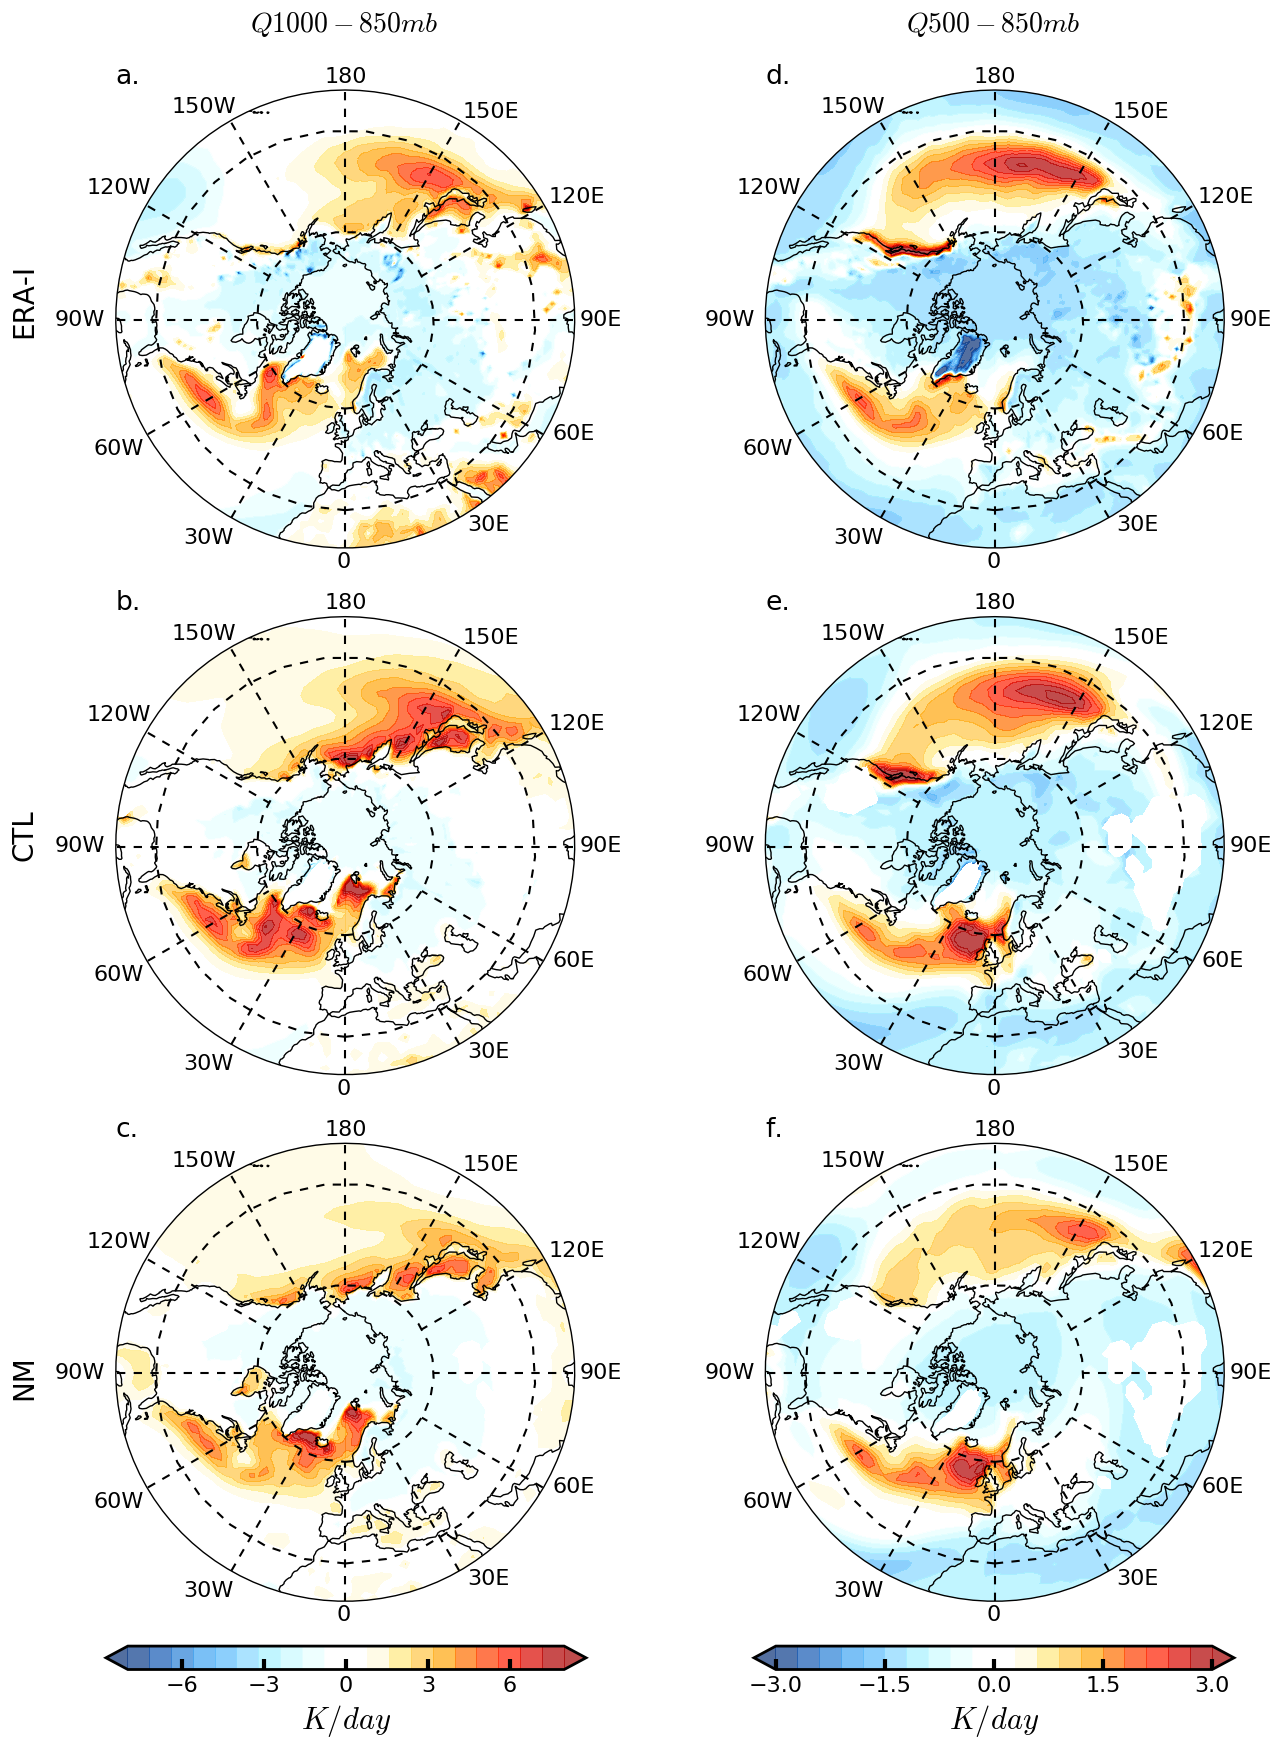

In [134]:
#Q 1000-850 Q 850-500,ERA-I, WACCM SOM CTL and NM and diffs - FINAL

# Read in ERA diabatic heating

nrows = 3;ncols=2

matplotlib.rcParams['figure.figsize']=(8*ncols,6.5*nrows)
matplotlib.rcParams.update({'font.size':16})

plt.rcParams["axes.linewidth"]  = 2
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8


seas='DJF'

n=1
DIAconst = 86400.0
ERAIconst = 86400.0

levels1 = np.arange(0,28.1,2.0)
levels2 = np.arange(-8,8.1,0.8)
levels3 = np.arange(-3,3.1,0.3)

levels1diffs = np.arange(-5,5.1,0.5)
levels2diffs = np.arange(-4,4.01,0.4)
levels3diffs = np.arange(-2,2.01,0.2)


fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.15)

# WACCM SOM
lev = 1000
lev0=850
lev1=850

PS_M = (atmfields['WACCM_CTL_SOM']['DJF']['PS'].mean(dim='time')) 
PS_NM = (atmfields['WACCM_flat_SOM']['DJF']['PS'].mean(dim='time')) 


toplotM_DIA = (DIAconst * (atmfields['pWACCM_CTL_SOM']['DJF']['DIA']
                          .mean(dim='time')).sel(lev_p = slice(lev,lev1)))
toplotNM_DIA = (DIAconst *(atmfields['pWACCM_flat_SOM']['DJF']['DIA']
                          .mean(dim='time')).sel(lev_p = slice(lev,lev1)))


lev2=850
lev3=500
toplotM_DIAlow = masswght_avg(toplotM_DIA,PS_M)
toplotNM_DIAlow = masswght_avg(toplotNM_DIA,PS_NM)

toplotM_DIA = (DIAconst * (atmfields['pWACCM_CTL_SOM']['DJF']['DIA']
                          .mean(dim='time')).sel(lev_p = slice(lev2,lev3)))
toplotNM_DIA = (DIAconst *(atmfields['pWACCM_flat_SOM']['DJF']['DIA']
                          .mean(dim='time')).sel(lev_p = slice(lev2,lev3)))

toplotM_DIAup = masswght_avg(toplotM_DIA,PS_M)
toplotNM_DIAup = masswght_avg(toplotNM_DIA,PS_NM)

mask = PS_M.copy(deep=True)
mask[...] = 0.0

mask.values = np.where(PS_M/100.0 > lev0,1.0,np.nan) 

# ERA Q 925-850
ax = set_NPstereo(ncols,nrows,n); n+=1

lev1=925
lev2=850
toplot = ERAIconst * ERAI['DJF']['Q'].sel(levelist=slice(lev2,lev1))


levs = toplot.levelist
nlevs = len(levs)
# find mid-point of levs:
midlevs = np.ndarray(nlevs + 1,float)
midlevs[0] = levs[0]
for ilev in range(0,nlevs-1):
    midlevs[ilev+1] = 0.5 * (levs[ilev+1] + levs[ilev])
    
midlevs[nlevs] = levs[-1]
wghtlevs = midlevs[0:nlevs] - midlevs[1:nlevs+1]

# first level
toplotwght = toplot.copy(deep=True)
toplotwght.values[...] = 0.0

for ilev in range(0,nlevs):
    toplotlev = toplot.isel(levelist=ilev) 
    toplotwght[ilev,:,:] = toplotlev * wghtlevs[ilev]

toplot = toplotwght.sum(dim='levelist') / wghtlevs.sum()
new_da = add_lon(toplot,coord='longitude')

im = plt.contourf(new_da.longitude, new_da.latitude,new_da.values,transform=ccrs.PlateCarree(),
    levels=levels2,cmap=cmap_wc,extend='both',linestyles='--',alpha=0.7)
title = ('a.')
plt.title(title,loc='left')
fig.text(0.25,0.93,r'$Q ' + str(lev) + '-' + str(lev0) + 'mb$',fontsize=20)


# ERA Q 850-500
ax = set_NPstereo(ncols,nrows,n); n+=1

lev2=850
lev3=500
toplot = ERAIconst * ERAI['DJF']['Q'].sel(levelist=slice(lev3,lev2))


levs = toplot.levelist
nlevs = len(levs)
# find mid-point of levs:
midlevs = np.ndarray(nlevs + 1,float)
midlevs[0] = levs[0]
for ilev in range(0,nlevs-1):
    midlevs[ilev+1] = 0.5 * (levs[ilev+1] + levs[ilev])
    
midlevs[nlevs] = levs[-1]
wghtlevs = midlevs[0:nlevs] - midlevs[1:nlevs+1]

# first level
toplotwght = toplot.copy(deep=True)
toplotwght.values[...] = 0.0

for ilev in range(0,nlevs):
    toplotlev = toplot.isel(levelist=ilev) 
    toplotwght[ilev,:,:] = toplotlev * wghtlevs[ilev]

toplot = toplotwght.sum(dim='levelist') / wghtlevs.sum()
new_da = add_lon(toplot,coord='longitude')

im = plt.contourf(new_da.longitude, new_da.latitude,new_da.values,transform=ccrs.PlateCarree(),
    levels=levels3,cmap=cmap_wc,extend='both',linestyles='--',alpha=0.7)
title = ('d.')
plt.title(title,loc='left')
fig.text(0.66,0.93,r'$Q ' + str(lev3) + '-' + str(lev2) + 'mb$',fontsize=20)


# CTL DIA850
ax = set_NPstereo(ncols,nrows,n); n+=1

toplot = toplotM_DIAlow
new_da = add_lon(toplot,coord='lon')
new_da_LM = add_lon(mask,coord='lon')

coord = 'lon'
lon_idx = toplot.dims.index(coord)
cyclic_data, cyclic_coord = add_cyclic_point(toplot.values,
                                             coord=toplot.coords[coord],
                                             axis=lon_idx)

im = plt.contourf(new_da.lon, new_da.lat,new_da.values * new_da_LM.values,transform=ccrs.PlateCarree(),
    levels=levels2,cmap=cmap_wc,extend='both',linestyles='--',alpha=0.7)

title = ('b.')
plt.title(title,loc='left')


# CTL DIA500
ax = set_NPstereo(ncols,nrows,n); n+=1

toplot = toplotM_DIAup
new_da = add_lon(toplot,coord='lon')
new_da_LM = add_lon(mask,coord='lon')

coord = 'lon'
lon_idx = toplot.dims.index(coord)
cyclic_data, cyclic_coord = add_cyclic_point(toplot.values,
                                             coord=toplot.coords[coord],
                                             axis=lon_idx)

im = plt.contourf(new_da.lon, new_da.lat,new_da.values * new_da_LM.values,transform=ccrs.PlateCarree(),
    levels=levels3,cmap=cmap_wc,extend='both',linestyles='--',alpha=0.7)

title = ('e.')
plt.title(title,loc='left')


# NM DIA
ax = set_NPstereo(ncols,nrows,n); n+=1

toplot = toplotNM_DIAlow
new_da = add_lon(toplot,coord='lon')
new_da_LM = add_lon(mask,coord='lon')

coord = 'lon'
lon_idx = toplot.dims.index(coord)
cyclic_data, cyclic_coord = add_cyclic_point(toplot.values,
                                             coord=toplot.coords[coord],
                                             axis=lon_idx)

im = plt.contourf(new_da.lon, new_da.lat,new_da.values * new_da_LM.values,transform=ccrs.PlateCarree(),
    levels=levels2,cmap=cmap_wc,extend='both',linestyles='--',alpha=0.7)

title = ('c.')
plt.title(title,loc='left')
cbar_ax = fig.add_axes([0.16, 0.09, 0.3, 0.012])
cbar_ax.tick_params(labelsize=16) 
ticks = [-6,-3,0,3,6]

cb = fig.colorbar(im,cax=cbar_ax,orientation='horizontal',ticks=ticks)
cb.set_label(label = r'$K/day$',fontsize=22)

# NM DIA
ax = set_NPstereo(ncols,nrows,n); n+=1

toplot = toplotNM_DIAup
new_da = add_lon(toplot,coord='lon')
new_da_LM = add_lon(mask,coord='lon')

coord = 'lon'
lon_idx = toplot.dims.index(coord)
cyclic_data, cyclic_coord = add_cyclic_point(toplot.values,
                                             coord=toplot.coords[coord],
                                             axis=lon_idx)

im = plt.contourf(new_da.lon, new_da.lat,new_da.values * new_da_LM.values,transform=ccrs.PlateCarree(),
    levels=levels3,cmap=cmap_wc,extend='both',linestyles='--',alpha=0.7)

title = ('f.')
plt.title(title,loc='left')
cbar_ax = fig.add_axes([0.565, 0.09, 0.3, 0.012])
cbar_ax.tick_params(labelsize=16) 
ticks = [-3,-1.5,0,1.5,3.0]
cb = fig.colorbar(im,cax=cbar_ax,orientation='horizontal',ticks = ticks)
cb.set_label(label = r'$K/day$',fontsize=22)

fig.text(0.1,0.80,'ERA-I',fontsize=20,rotation=90)
fig.text(0.1,0.52,'CTL',fontsize=20,rotation=90)
fig.text(0.1,0.24,'NM',fontsize=20,rotation=90)

plt.savefig('/home/disk/eos4/rachel/Projects/StationaryWaves/FiguresJAS/Fig7Q.eps', dpi=None, facecolor='w', 
        edgecolor='w',
        orientation='portrait')

plt.show()

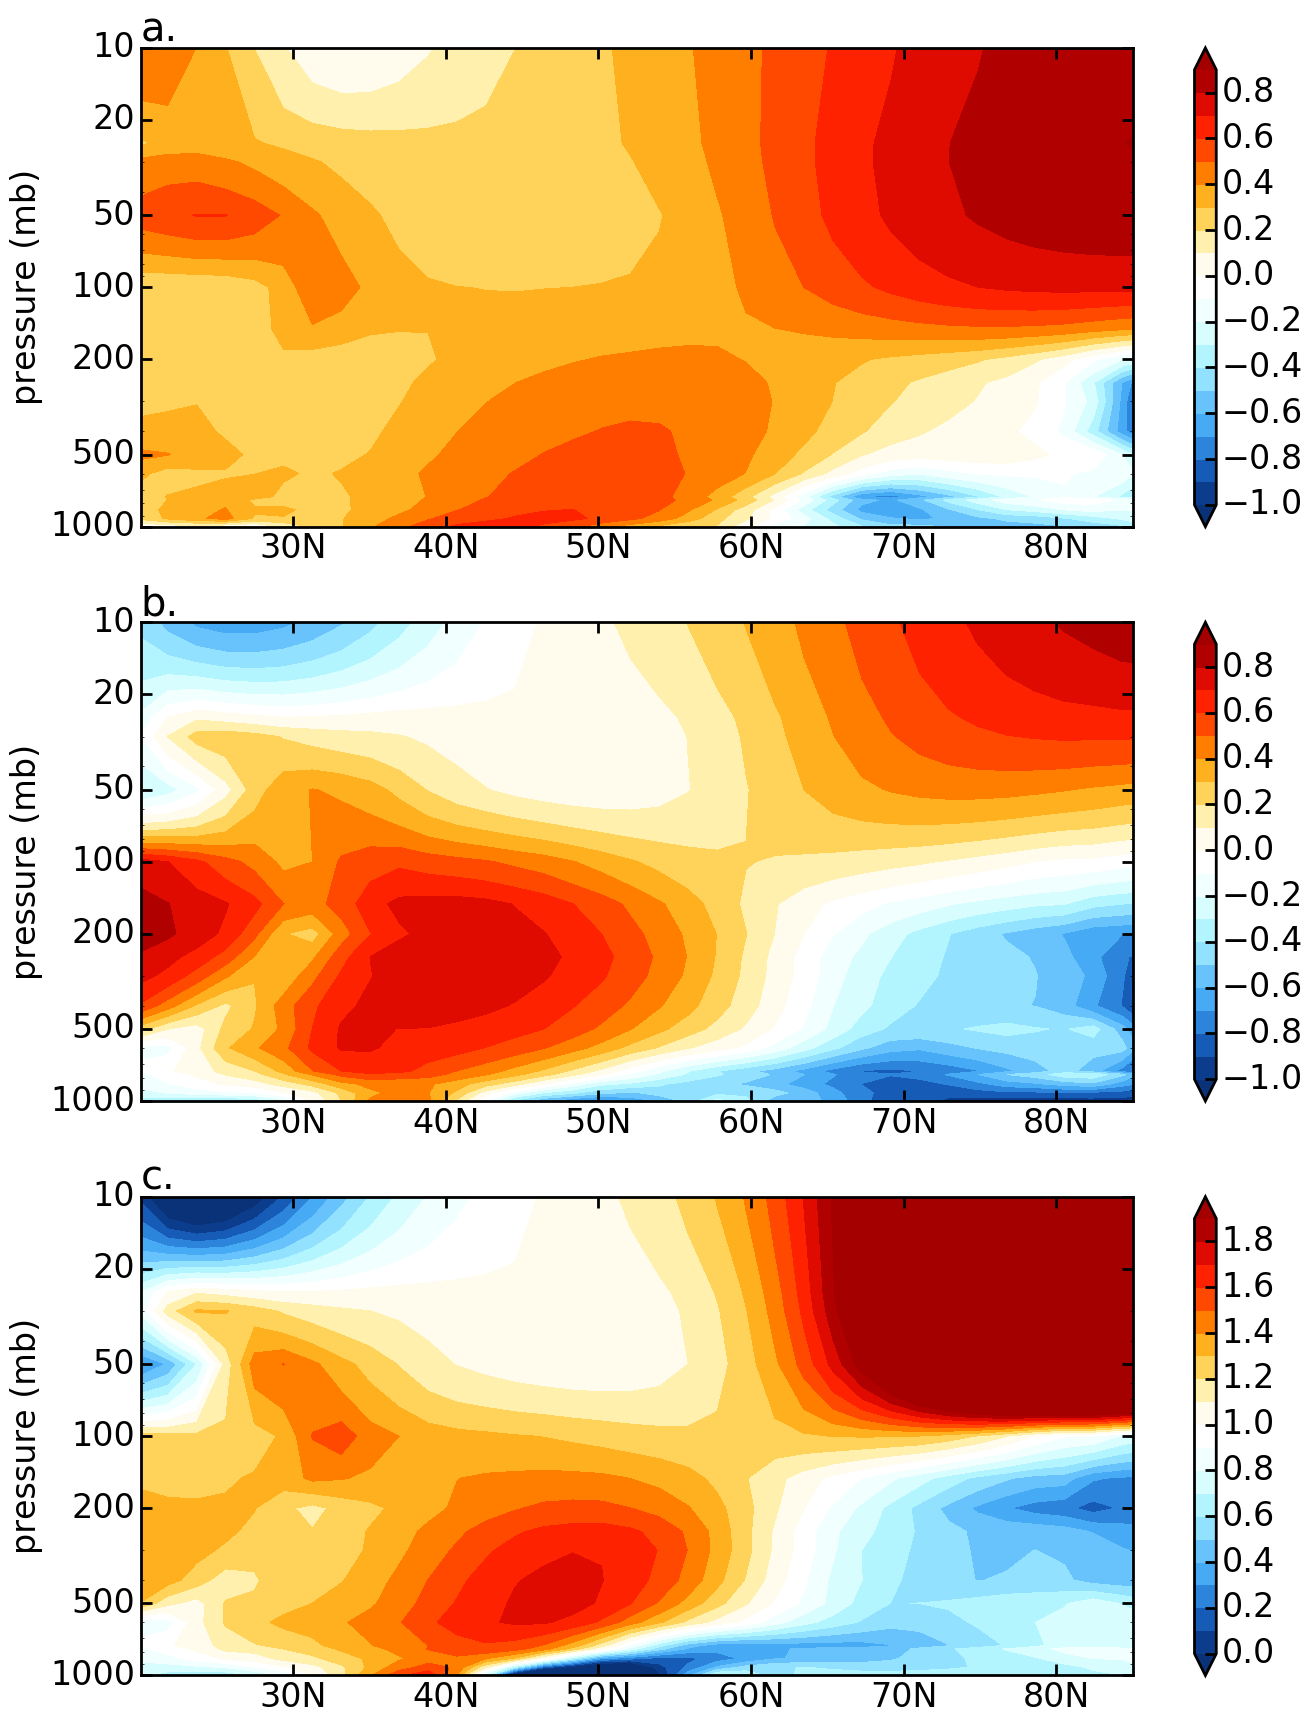

In [133]:
### Plot strength, correlation coefficient and amplitude
nrows = 3

matplotlib.rcParams['figure.figsize']=(16,7*nrows)
matplotlib.rcParams.update({'font.size':20})
plt.rcParams["axes.linewidth"]  = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8

exp1 = 'WACCM_CTL_fSST'
exp2 = 'WACCM_flat_fSST'

var = 'Z3'

lat1 = 10
lat2 = 90

varM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = varM.lat
try:
    levs = varM.lev_p
except AttributeError:
    levs = varM.lev_int
        

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),varM.isel(lev_int = ilev),np.nan)
        
    try:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        tempNM = np.where(varPS > (lev * 100.0),varNM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]
    varNM[ilev,:,:] = tempNM[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')


n=1

pt = 10

vmin0 = -100; vmax0=100
vmin = -100; vmax = 100
nlevels0 = 16
nlevels = 16
cenlon = 0
levelsC = np.arange(-1,1,0.1)

levelsA = np.arange(0,2.0,0.1)
#plot WACCM
# WACCM SOM
plt.subplot(nrows,1,n); n+=1

invarC_std = varM.std(dim='lon')
invarNM_std = varNM.std(dim='lon')
Mstrength = (invarC_std - invarNM_std)/invarC_std

plt.contourf(varM.lat, varM.lev_p,Mstrength.values,
    levels=levelsC,cmap=cmap_wc,extend='both')
plt.colorbar(extend='both')

setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('a.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')



## Correlation subplot

# Correlation Z3 for SOM
matplotlib.rcParams['figure.figsize']=(16,8)
matplotlib.rcParams.update({'font.size':24})

var = 'Z3'

lat1 = 10
lat2 = 90

tempM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        
varM = tempM.copy(deep=True)

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')

corr_rs,corr_ps = pearson_regress_cs(varNM,varM)

plt.subplot(nrows,1,n); n+=1

plt.contourf(varM.lat, varM.lev_p,corr_rs.values,
    levels=levelsC,cmap=cmap_wc,extend='both')
plt.colorbar(extend='upper')

setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('b.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')


## Amplification subplot

# Calculate amplification factor

var = 'Z3'

lat1 = 10
lat2 = 90

tempM = atmfields['p' + exp1]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))
varNM = atmfields['p' + exp2]['DJF'][var].mean(dim='time').sel(lat=slice(lat1,lat2))

varPS = atmfields[exp1]['DJF']['PS'].mean(dim='time').sel(lat=slice(lat1,lat2))

lats = tempM.lat
try:
    levs = tempM.lev_p
except AttributeError:
    levs = tempM.lev_int
        
varM = tempM.copy(deep=True)

for ilev in np.arange(0,len(levs)):
    lev = levs[ilev]
    try:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_p = ilev),np.nan)
    except AttributeError:
        temp = np.where(varPS > (lev * 100.0),tempM.isel(lev_int = ilev),np.nan)
        
    varM[ilev,:,:] = temp[:,:]

varM = varM - varM.mean(dim='lon')
varNM = varNM - varNM.mean(dim='lon')

amp_rs,amp_ps = amplification_factor(varNM,varM)


plt.subplot(nrows,1,n); n+=1

ps_mask = np.where(amp_ps < 0.01,np.nan,1.0)

plt.contourf(varM.lat, varM.lev_p,amp_rs.values,
    levels=levelsA,cmap=cmap_wc,extend='both')
plt.colorbar(extend='upper')

#plt.contourf(varM.lat, varM.lev_p,ps_mask,linecolors='white',
#    levels=[0,2],colors = 'none',hatches=['.'],extend='both')


setaxes_latN('','',ps=1000,pt=pt,log=True)    
plt.title('c.',loc='left')
plt.xlim(20,85)
plt.ylabel('pressure (mb)')

plt.savefig('/home/disk/eos4/rachel/Projects/StationaryWaves/FiguresJAS/Fig8corr_amp_fSST.eps', dpi=None, facecolor='w', 
        edgecolor='w',
        orientation='portrait')

plt.show()


